# **Import the Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# **Data Set: Features_COVID_Record_ID_new**

## **Main**

In [4]:
#import data 
data1 = pd.read_excel('data1.xlsx')

In [5]:
a = data1.isna().sum()
a = pd.DataFrame(a)
a.reset_index(inplace = True)
s = list(range(0,689))
a.reindex(s)
a.columns = ['feature_names' , 'mvs_number']

In [6]:
#find features with more than 20% NA
b = a[a['mvs_number']>= 200]

In [7]:
#delete 12 features 
a.drop(list(range(401,413)) , axis = 0 , inplace = True)

In [8]:
#put data1 in another dataframe to do eliminations easier 
data1_ = data1

In [9]:
#eliminate features from data1_
data1_.drop(b['feature_names'] , axis = 1 , inplace = True)

In [10]:
#impute NA values using KNN with k=5
imputer = KNNImputer(n_neighbors = 5)

In [11]:
data1_ = imputer.fit_transform(data1_)

In [12]:
#make imputed array as dataframe
data1_ = pd.DataFrame(data1_ , columns = list(a['feature_names']))

In [13]:
#count values in (lable -> y)
data1_.groupby('Label').count()

,Record_Name,TWaveAsymm,AvgTWavePower,Vindex,Sex,Age,PP_1.0_Values,PP_1.0_Samples_1,PP_1.0_Samples_2,PP_2.0_Values,...,QRS_Pseudo_Vector_7/8_Spatial_Velocity,QRS_Pseudo_Vector_Maximum_Amplitude,LVH_Score,LV_Strain,ST_Duration,PR_Interval,QT_Interval,QT_Dispersion,QT_Corrected,P_Terminal
Label,,,,,,,,,,,,,,,,,,,,,
0.0,851,851,851,851,851,851,851,851,851,851,...,851,851,851,851,851,851,851,851,851,851
1.0,153,153,153,153,153,153,153,153,153,153,...,153,153,153,153,153,153,153,153,153,153


In [14]:
#check that is there na values or no?
pd.isnull(data1_.loc[648,]).sum()

0

In [15]:
#a function for find outliers using tukey method 
def tukey(df,colname):
    q1 = df[colname].quantile(0.25)
    q3 = df[colname].quantile(0.75)
    iqr = q3-q1
    lower_lim = q1-1.5*iqr
    upper_lim = q3+1.5*iqr
    outlier_low = (df[colname] < lower_lim)
    outlier_up = (df[colname] > upper_lim)
    df_out = df.loc[(outlier_low|outlier_up)]
    z = df_out.index
    df[colname].values[(outlier_low|outlier_up)] = np.nan
    
    return(lower_lim , upper_lim , z , df)
    

In [16]:
data1_.groupby('Label').count()

,Record_Name,TWaveAsymm,AvgTWavePower,Vindex,Sex,Age,PP_1.0_Values,PP_1.0_Samples_1,PP_1.0_Samples_2,PP_2.0_Values,...,QRS_Pseudo_Vector_7/8_Spatial_Velocity,QRS_Pseudo_Vector_Maximum_Amplitude,LVH_Score,LV_Strain,ST_Duration,PR_Interval,QT_Interval,QT_Dispersion,QT_Corrected,P_Terminal
Label,,,,,,,,,,,,,,,,,,,,,
0.0,851,851,851,851,851,851,851,851,851,851,...,851,851,851,851,851,851,851,851,851,851
1.0,153,153,153,153,153,153,153,153,153,153,...,153,153,153,153,153,153,153,153,153,153


In [17]:
#put label in a list 
label = data1_['Label']

In [18]:
#drop label(response variable) not to create any NA 
data1_.drop(['Label'] , axis = 1 , inplace = True)

In [19]:
# the loop for eliminate outliers using the function defined 
for col in data1_.columns:
    tukey(data1_ , col)

In [20]:
#add label column to dataframe 
data1_['Label'] = label

In [21]:
#impute na values created in outlier detection 
data1_ = imputer.fit_transform(data1_)

In [22]:
data1_ = pd.DataFrame(data1_ , columns = list(a['feature_names']))

In [23]:
#create correlation matrix 
data1_.corr()

,Record_Name,TWaveAsymm,AvgTWavePower,Vindex,Sex,Age,PP_1.0_Values,PP_1.0_Samples_1,PP_1.0_Samples_2,PP_2.0_Values,...,QRS_Pseudo_Vector_Maximum_Amplitude,LVH_Score,LV_Strain,ST_Duration,PR_Interval,QT_Interval,QT_Dispersion,QT_Corrected,P_Terminal,Label
Record_Name,1.000000,-0.029731,-0.091090,0.022476,0.014159,0.010585,0.010160,0.050664,0.035043,-0.010182,...,-0.064391,-0.000042,NaN,0.034733,0.039128,0.000456,0.019109,0.026066,-0.014731,0.110955
TWaveAsymm,-0.029731,1.000000,0.119241,0.191250,0.107962,0.122269,-0.188777,-0.142196,-0.197103,-0.176880,...,0.110555,0.137366,NaN,-0.374095,-0.000526,-0.099679,0.089922,0.068907,-0.045630,0.128509
AvgTWavePower,-0.091090,0.119241,1.000000,-0.091274,0.217439,-0.099762,0.014442,-0.042911,-0.016290,0.010447,...,0.208944,0.035922,NaN,-0.078808,-0.061182,-0.000406,-0.139460,-0.018089,-0.029994,0.012086
Vindex,0.022476,0.191250,-0.091274,1.000000,0.061957,0.209003,0.072581,0.070091,0.096956,0.080231,...,0.094440,0.185308,NaN,-0.074470,0.078933,0.174817,0.116891,0.226310,-0.087979,0.123093
Sex,0.014159,0.107962,0.217439,0.061957,1.000000,-0.084160,0.102852,-0.015706,0.050984,0.098302,...,0.071903,-0.020154,NaN,-0.075376,0.055038,0.124268,0.031585,0.086259,-0.006562,-0.006584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QT_Interval,0.000456,-0.099679,-0.000406,0.174817,0.124268,0.254091,0.727848,0.149995,0.505864,0.738098,...,0.138810,0.104962,NaN,0.233295,0.266181,1.000000,0.102792,0.787918,0.018436,-0.008389
QT_Dispersion,0.019109,0.089922,-0.139460,0.116891,0.031585,0.144938,0.050135,-0.012538,0.027968,0.027889,...,-0.038487,0.040790,NaN,-0.121348,0.024649,0.102792,1.000000,0.111962,-0.022765,0.061476
QT_Corrected,0.026066,0.068907,-0.018089,0.226310,0.086259,0.410555,0.312096,0.078272,0.255052,0.327916,...,0.140160,0.217397,NaN,0.064391,0.202172,0.787918,0.111962,1.000000,-0.098042,0.158402
P_Terminal,-0.014731,-0.045630,-0.029994,-0.087979,-0.006562,-0.096793,0.101385,0.013378,0.039351,0.116164,...,0.070233,-0.167468,NaN,0.097226,-0.065456,0.018436,-0.022765,-0.098042,1.000000,-0.073291


<AxesSubplot:>

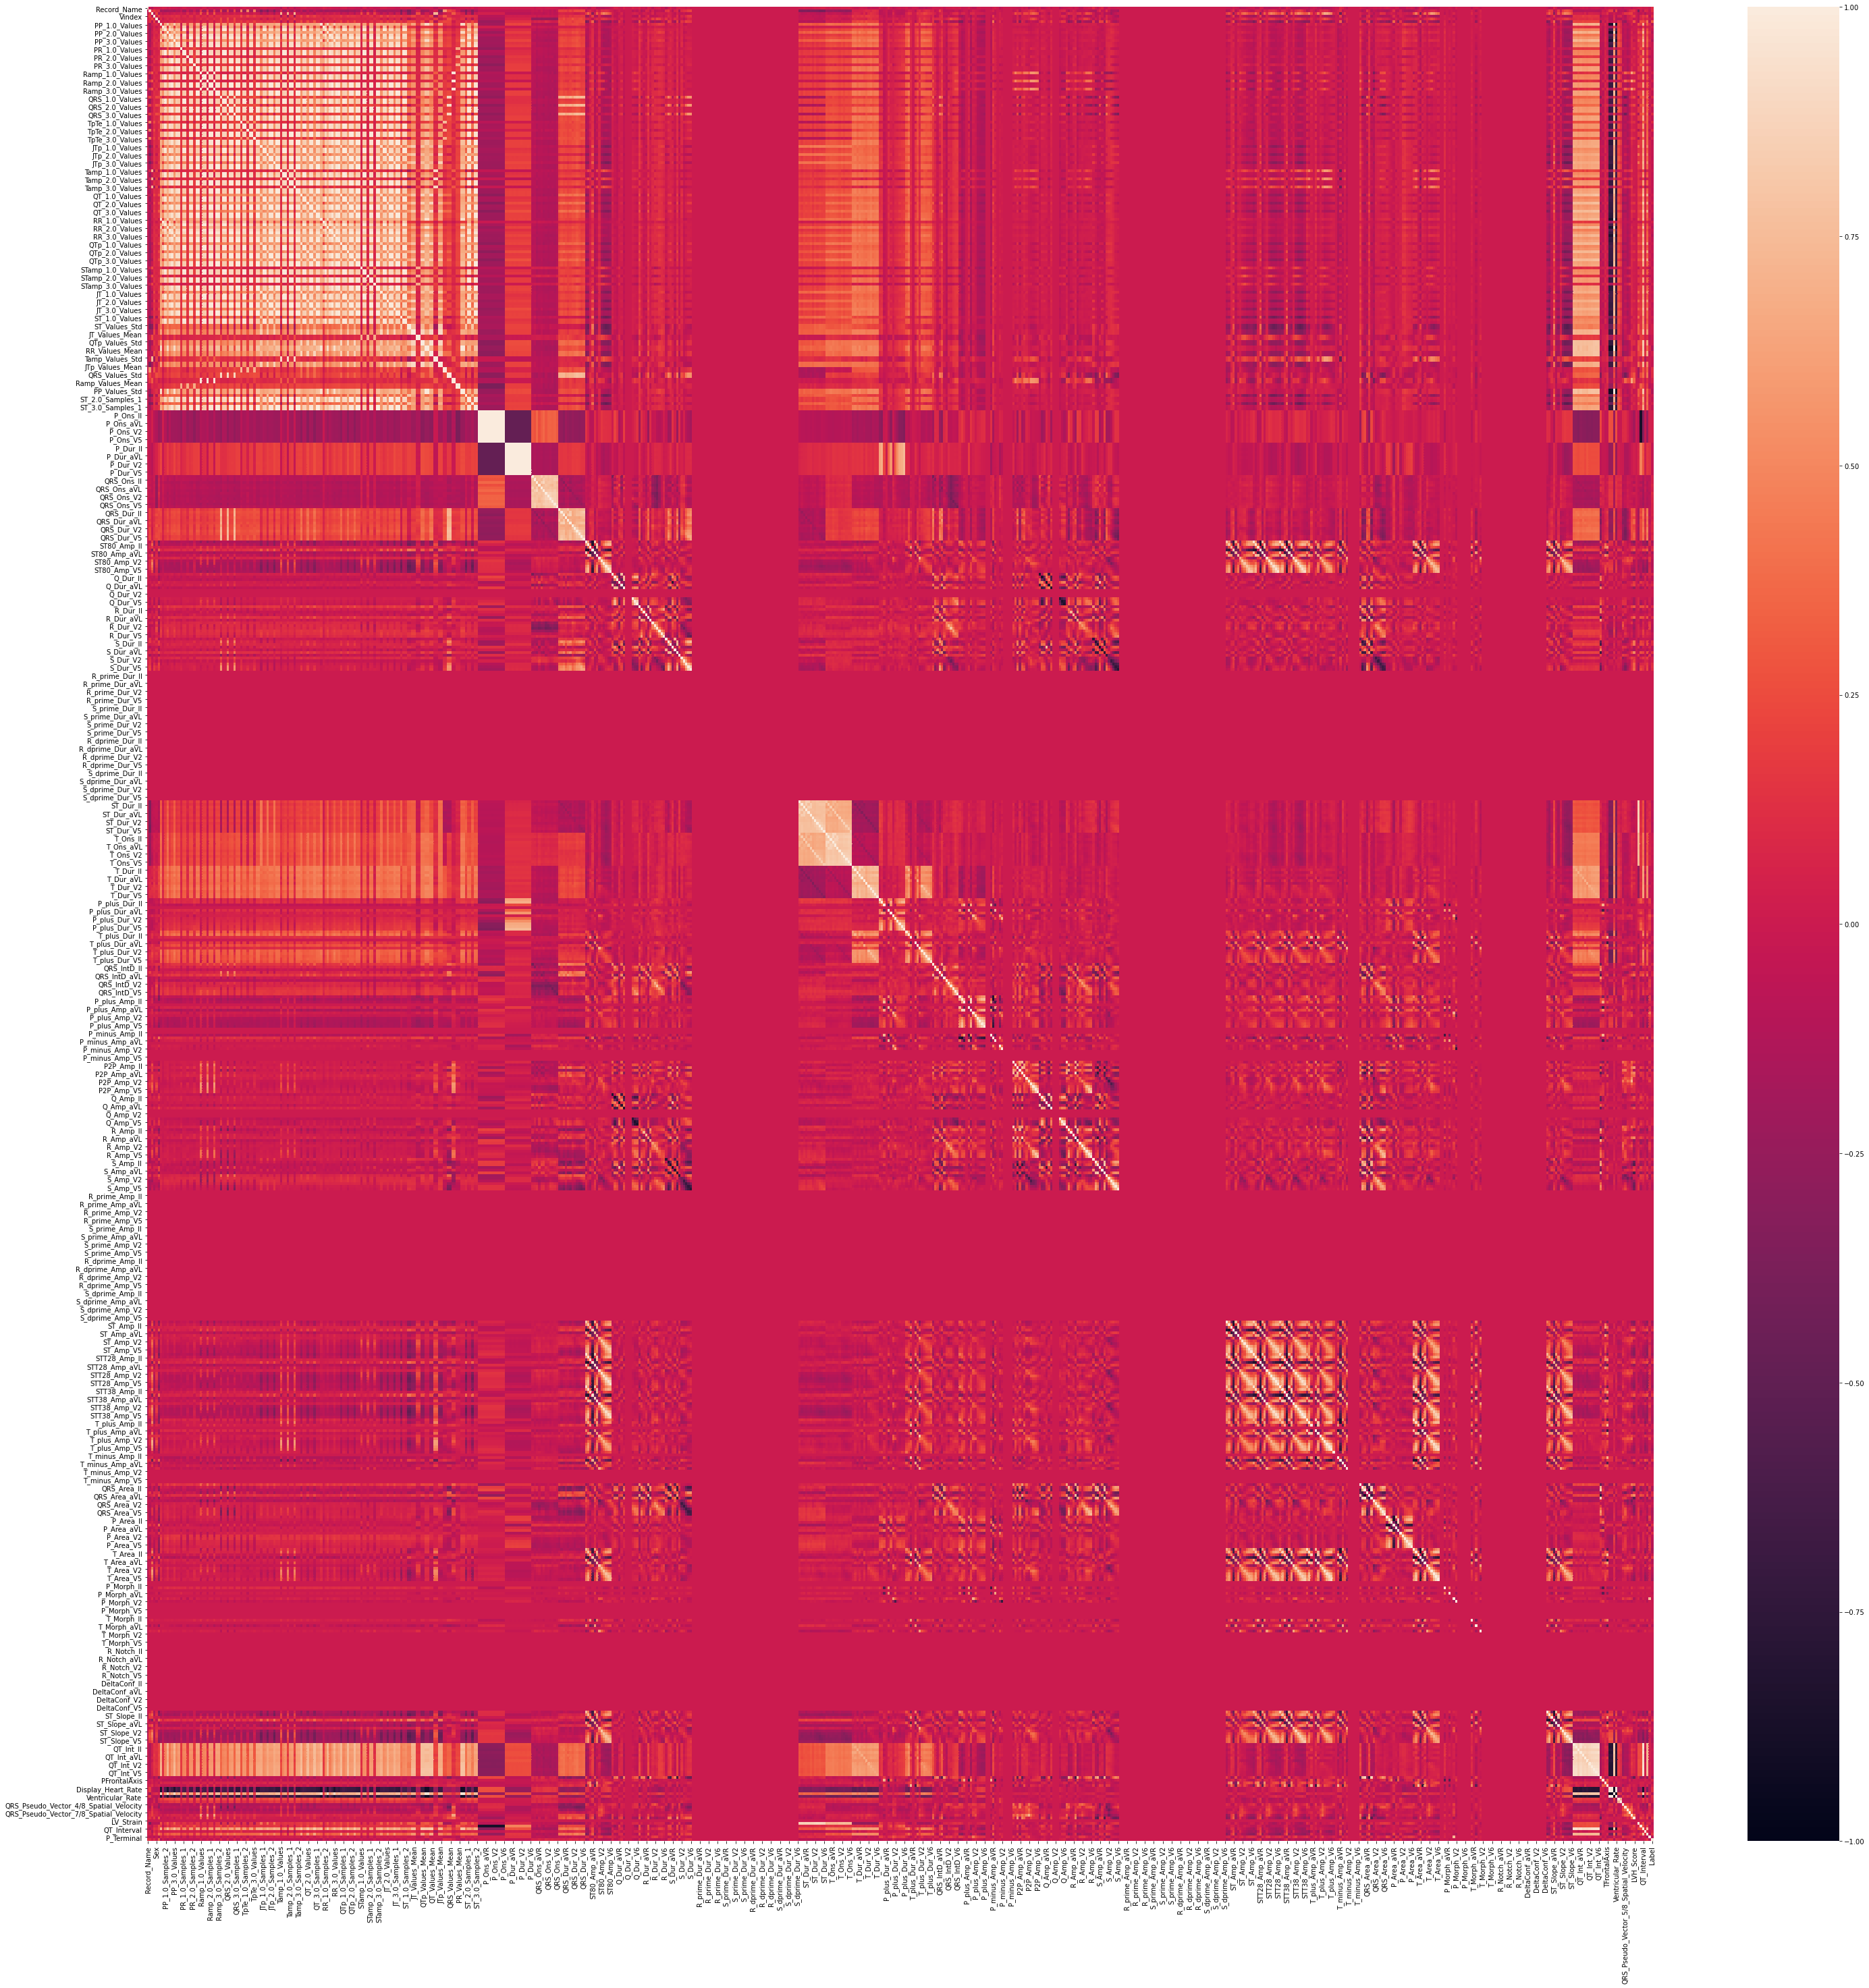

In [24]:
fig = plt.figure(figsize = (50,50))
sns.heatmap(data1_.corr().replace(np.NaN,0), vmin = -1, vmax = +1)

<AxesSubplot:>

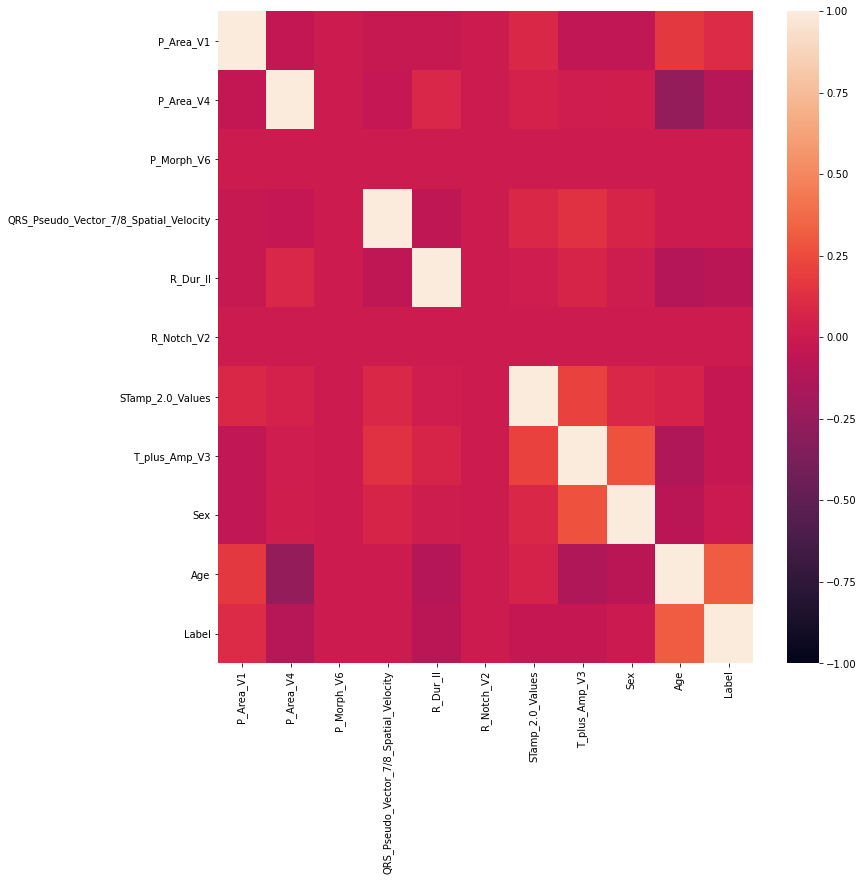

In [25]:
data1_new = data1_[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age','Label']]
fig = plt.figure(figsize = (12,12))
sns.heatmap(data1_new.corr().replace(np.NaN,0), vmin = -1, vmax = +1)

In [26]:
data1_['Label'].value_counts()

0.0    851
1.0    153
Name: Label, dtype: int64

<AxesSubplot:>

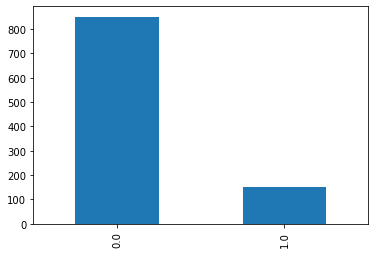

In [27]:
data1_['Label'].value_counts().plot(kind = 'bar')

# **Modeling**

In [28]:
X = data1_.loc[:,data1_.columns != 'Label']
Y = data1_.loc[:,data1_.columns == 'Label']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state = 0)    
 
#Train data and test Data
train_df = pd.concat([X_train, y_train], axis = 1)
test_df = pd.concat([X_test, y_test], axis = 1)

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rf = RandomForestClassifier()
stratifiedkf = StratifiedKFold(n_splits = 3, shuffle= True, )
score = cross_val_score(rf, X_train, y_train, cv = stratifiedkf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))
print("Std Cross Validation score :{}".format(score.std()))

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Cross Validation Scores are [0.87017544 0.85915493 0.85915493]
Average Cross Validation score :0.8628284325838069
Std Cross Validation score :0.005195117772987437


In [32]:
#Interval of Cross Validation
LB = score.mean() - score.std()
UB = score.mean() + score.std()
print(LB,UB)

0.8576333148108195 0.8680235503567943


In [33]:
for fold, (train_index, valid_index) in enumerate(stratifiedkf.split(X_train, y_train),1):
    X_train_f = X.iloc[train_index,:]
    y_train_f = Y.iloc[train_index,:]
    X_valid_f = X.iloc[valid_index,:]
    y_valid_f = Y.iloc[valid_index,:]

In [34]:
X_train.shape

(853, 676)

In [35]:
X_train_f.shape

(569, 676)

In [36]:
X_valid_f.shape

(284, 676)

In [37]:
train_df_f = pd.concat([X_train_f, y_train_f], axis = 1)
train_df_f_0 = train_df_f[train_df_f["Label"] == 0].sample(n = 430)
train_df_f_1 = train_df_f[train_df_f["Label"] == 1]
train_df_f1 = pd.concat([train_df_f_0, train_df_f_1], axis = 0)

# ***BOX PLOTS Before subsets***

In [50]:
df_fs = train_df_f1[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age','Label']].reset_index().drop("index", axis = 1)

In [51]:
df_0 = df_fs[df_fs["Label"] == 0]
df_1 = df_fs[df_fs["Label"] == 1]

In [53]:
datam_morto_1 = df_1.head(27).replace({"Label" : 1}, 1)
datam_morto_2= df_1.iloc[27:54,:].replace({"Label" : 1}, 2)
datam_morto_3 = df_1.tail(27).replace({"Label" : 1}, 3)

In [54]:
sub1m = pd.concat([df_0,datam_morto_1,datam_morto_2,datam_morto_3], axis = 0).reset_index().drop("index", axis = 1)

In [56]:
#Feature 1
df1m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_0"})
df1m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_1"})
df1m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_2"})
df1m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_3"})
df1m_t1 = pd.concat([df1m_01,df1m_11,df1m_21,df1m_31], axis = 1)

#Feature 2
df2m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_0"})
df2m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_1"})
df2m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_2"})
df2m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_3"})
df2m_t1 = pd.concat([df2m_01,df2m_11,df2m_21,df2m_31], axis = 1)

#Feature 3
df3m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_0"})
df3m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_1"})
df3m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_2"})
df3m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_3"})
df3m_t1 = pd.concat([df3m_01,df3m_11,df3m_21,df3m_31], axis = 1)

#Feature 4
df4m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_0"})
df4m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_1"})
df4m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_2"})
df4m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_3"})
df4m_t1 = pd.concat([df4m_01,df4m_11,df4m_21,df4m_31], axis = 1)
#Feature 5
df5m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_0"})
df5m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_1"})
df5m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_2"})
df5m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_3"})
df5m_t1 = pd.concat([df5m_01,df5m_11,df5m_21,df5m_31], axis = 1)

#Feature 6
df6m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_0"})
df6m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_1"})
df6m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_2"})
df6m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_3"})
df6m_t1 = pd.concat([df6m_01,df6m_11,df6m_21,df6m_31], axis = 1)

#Feature 7
df7m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_0"})
df7m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_1"})
df7m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_2"})
df7m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_3"})
df7m_t1 = pd.concat([df7m_01,df7m_11,df7m_21,df7m_31], axis = 1)

#Feature 8
df8m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_0"})
df8m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_1"})
df8m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_2"})
df8m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_3"})
df8m_t1 = pd.concat([df8m_01,df8m_11,df8m_21,df8m_31], axis = 1)

#Feature 9
df9m_01 = sub1m[sub1m["Label"] == 0].iloc[:,[9]].rename(columns = {"Age" : "Age_0"})
df9m_11 = sub1m[sub1m["Label"] == 1].iloc[:,[9]].rename(columns = {"Age" : "Age_1"})
df9m_21 = sub1m[sub1m["Label"] == 2].iloc[:,[9]].rename(columns = {"Age" : "Age_2"})
df9m_31 = sub1m[sub1m["Label"] == 3].iloc[:,[9]].rename(columns = {"Age" : "Age_3"})
df9m_t1 = pd.concat([df9m_01,df9m_11,df9m_21,df9m_31], axis = 1)

<AxesSubplot:>

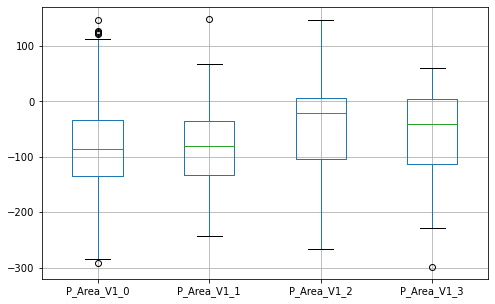

In [75]:
fig = plt.figure(figsize = (8,5))
df1m_t1.boxplot()

<AxesSubplot:>

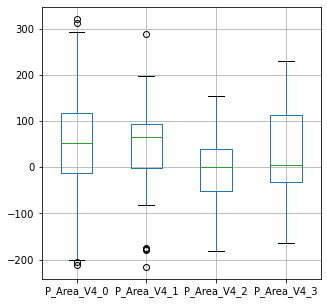

In [60]:
fig = plt.figure(figsize = (5,5))
df2m_t1.boxplot()

<AxesSubplot:>

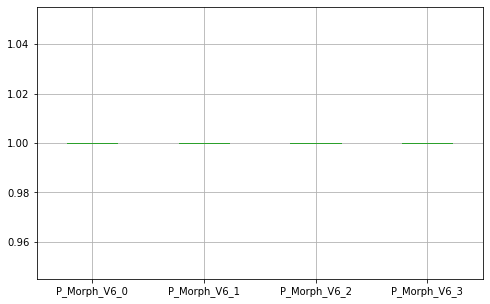

In [62]:
fig = plt.figure(figsize = (8,5))
df3m_t1.boxplot()

<AxesSubplot:>

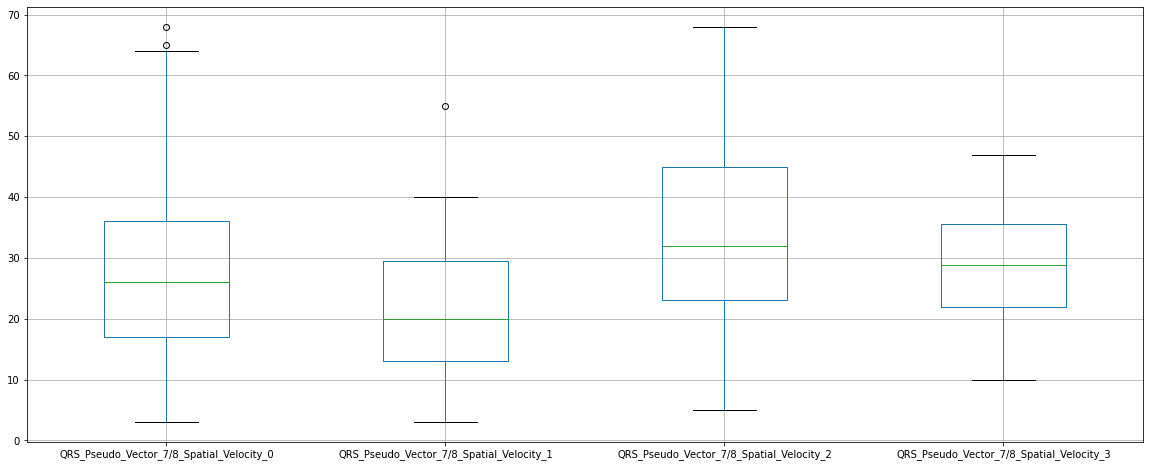

In [66]:
fig = plt.figure(figsize = (20,8))
df4m_t1.boxplot()

<AxesSubplot:>

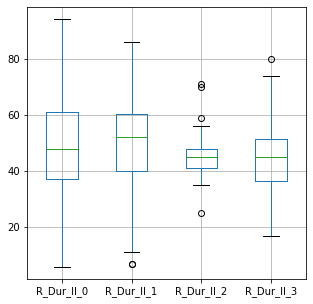

In [67]:
fig = plt.figure(figsize = (5,5))
df5m_t1.boxplot()

<AxesSubplot:>

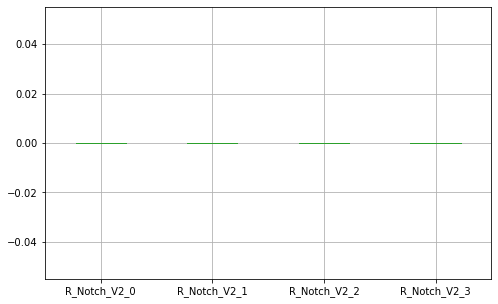

In [69]:
fig = plt.figure(figsize = (8,5))
df6m_t1.boxplot()

<AxesSubplot:>

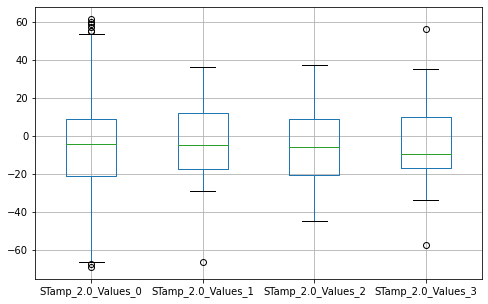

In [71]:
fig = plt.figure(figsize = (8,5))
df7m_t1.boxplot()

<AxesSubplot:>

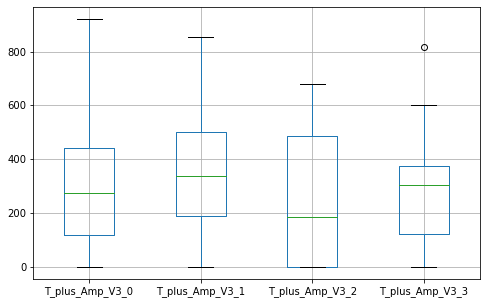

In [73]:
fig = plt.figure(figsize = (8,5))
df8m_t1.boxplot()

<AxesSubplot:>

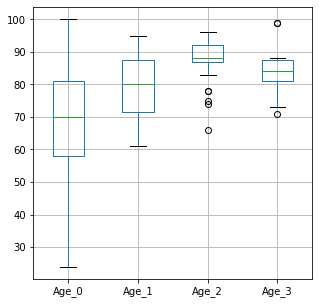

In [74]:
fig = plt.figure(figsize = (5,5))
df9m_t1.boxplot()

# ***DESIGNING SUBSETS***

In [77]:
train_df_f1.Label.value_counts()

0.0    430
1.0     82
Name: Label, dtype: int64

In [78]:
c1 = train_df_f1[train_df_f1['Label'] == 1 ]

In [79]:
c2 =  train_df_f1[train_df_f1['Label'] == 0 ]

In [80]:
c2_split = np.array_split(c2, 5)
c2_split[4].shape

(86, 677)

In [81]:
class1 , class2  = train_df_f1['Label'].value_counts()
c2_1 = c2_split[0]
c2_2 = c2_split[1]
c2_3 = c2_split[2]
c2_4 = c2_split[3]
c2_5 = c2_split[4]

In [82]:
sub1 = c2_1.sample(class2)
sub2 = c2_2.sample(class2)
sub3 = c2_3.sample(class2)
sub4 = c2_4.sample(class2)
sub5 = c2_5.sample(class2)

In [83]:
sub1 = pd.concat([sub1 , c1 ], axis = 0)
sub2 = pd.concat([sub2 , c1 ], axis = 0)
sub3 = pd.concat([sub3 , c1 ], axis = 0)
sub4 = pd.concat([sub4 , c1 ], axis = 0)
sub5 = pd.concat([sub5 , c1 ], axis = 0)

In [84]:
sub1['Label'].value_counts()

0.0    82
1.0    82
Name: Label, dtype: int64

In [85]:
X_valid_f =  X_valid_f[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age']]

# ***Subset1***

In [86]:
#After Feature Selection
sub1_1 = sub1[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age','Label']].reset_index().drop("index", axis = 1)

sub1_1

,P_Area_V1,P_Area_V4,P_Morph_V6,QRS_Pseudo_Vector_7/8_Spatial_Velocity,R_Dur_II,R_Notch_V2,STamp_2.0_Values,T_plus_Amp_V3,Sex,Age,Label
0,-108.0,80.0,1.0,14.0,49.0,0.0,-32.50,121.0,0.0,61.0,0.0
1,-81.0,90.0,1.0,5.0,43.0,0.0,11.25,71.0,0.0,76.0,0.0
2,-133.0,8.0,1.0,49.0,14.0,0.0,-48.75,0.0,1.0,70.0,0.0
3,-17.0,87.0,1.0,3.0,42.0,0.0,-38.75,230.0,0.0,78.0,0.0
4,-188.0,-48.0,1.0,27.0,86.0,0.0,-23.75,0.0,1.0,63.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
159,-74.0,-37.0,1.0,32.0,36.0,0.0,8.75,401.0,0.0,88.0,1.0
160,54.0,-163.0,1.0,21.0,30.0,0.0,26.25,384.0,0.0,88.0,1.0
161,5.8,-137.8,1.0,28.0,35.0,0.0,-8.75,318.0,0.0,88.0,1.0
162,0.0,-1.0,1.0,26.0,80.0,0.0,-17.50,303.0,1.0,86.0,1.0


In [87]:
sub1_1_0 = sub1_1[sub1_1["Label"] == 0]
sub1_1_1 = sub1_1[sub1_1["Label"] == 1]

In [88]:
data_morto_1 = sub1_1_1.head(29).replace({"Label" : 1}, 1)
data_morto_2= sub1_1_1.iloc[29:57,:].replace({"Label" : 1}, 2)
data_morto_3 = sub1_1_1.tail(29).replace({"Label" : 1}, 3)

In [89]:
sub1 = pd.concat([sub1_1_0,data_morto_1,data_morto_2,data_morto_3], axis = 0).reset_index().drop("index", axis = 1)

In [90]:
#Feature 1
df1_01 = sub1[sub1["Label"] == 0].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_0"})
df1_11 = sub1[sub1["Label"] == 1].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_1"})
df1_21 = sub1[sub1["Label"] == 2].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_2"})
df1_31 = sub1[sub1["Label"] == 3].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_3"})
df1_t1 = pd.concat([df1_01,df1_11,df1_21,df1_31], axis = 1)

#Feature 2
df2_01 = sub1[sub1["Label"] == 0].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_0"})
df2_11 = sub1[sub1["Label"] == 1].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_1"})
df2_21 = sub1[sub1["Label"] == 2].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_2"})
df2_31 = sub1[sub1["Label"] == 3].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_3"})
df2_t1 = pd.concat([df2_01,df2_11,df2_21,df2_31], axis = 1)

#Feature 3
df3_01 = sub1[sub1["Label"] == 0].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_0"})
df3_11 = sub1[sub1["Label"] == 1].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_1"})
df3_21 = sub1[sub1["Label"] == 2].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_2"})
df3_31 = sub1[sub1["Label"] == 3].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_3"})
df3_t1 = pd.concat([df3_01,df3_11,df3_21,df3_31], axis = 1)

#Feature 4
df4_01 = sub1[sub1["Label"] == 0].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_0"})
df4_11 = sub1[sub1["Label"] == 1].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_1"})
df4_21 = sub1[sub1["Label"] == 2].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_2"})
df4_31 = sub1[sub1["Label"] == 3].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_3"})
df4_t1 = pd.concat([df4_01,df4_11,df4_21,df4_31], axis = 1)
#Feature 5
df5_01 = sub1[sub1["Label"] == 0].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_0"})
df5_11 = sub1[sub1["Label"] == 1].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_1"})
df5_21 = sub1[sub1["Label"] == 2].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_2"})
df5_31 = sub1[sub1["Label"] == 3].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_3"})
df5_t1 = pd.concat([df5_01,df5_11,df5_21,df5_31], axis = 1)

#Feature 6
df6_01 = sub1[sub1["Label"] == 0].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_0"})
df6_11 = sub1[sub1["Label"] == 1].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_1"})
df6_21 = sub1[sub1["Label"] == 2].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_2"})
df6_31 = sub1[sub1["Label"] == 3].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_3"})
df6_t1 = pd.concat([df6_01,df6_11,df6_21,df6_31], axis = 1)

#Feature 7
df7_01 = sub1[sub1["Label"] == 0].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_0"})
df7_11 = sub1[sub1["Label"] == 1].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_1"})
df7_21 = sub1[sub1["Label"] == 2].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_2"})
df7_31 = sub1[sub1["Label"] == 3].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_3"})
df7_t1 = pd.concat([df7_01,df7_11,df7_21,df7_31], axis = 1)

#Feature 8
df8_01 = sub1[sub1["Label"] == 0].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_0"})
df8_11 = sub1[sub1["Label"] == 1].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_1"})
df8_21 = sub1[sub1["Label"] == 2].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_2"})
df8_31 = sub1[sub1["Label"] == 3].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_3"})
df8_t1 = pd.concat([df8_01,df8_11,df8_21,df8_31], axis = 1)

#Feature 9
df9_01 = sub1[sub1["Label"] == 0].iloc[:,[9]].rename(columns = {"Age" : "Age_0"})
df9_11 = sub1[sub1["Label"] == 1].iloc[:,[9]].rename(columns = {"Age" : "Age_1"})
df9_21 = sub1[sub1["Label"] == 2].iloc[:,[9]].rename(columns = {"Age" : "Age_2"})
df9_31 = sub1[sub1["Label"] == 3].iloc[:,[9]].rename(columns = {"Age" : "Age_3"})
df9_t1 = pd.concat([df9_01,df9_11,df9_21,df9_31], axis = 1)

<AxesSubplot:>

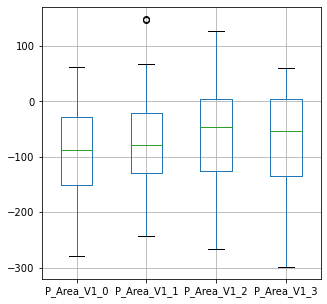

In [91]:
fig = plt.figure(figsize = (5,5))
df1_t1.boxplot()

<AxesSubplot:>

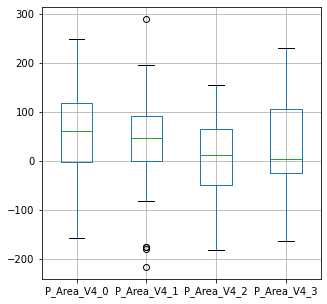

In [92]:
fig = plt.figure(figsize = (5,5))
df2_t1.boxplot()

<AxesSubplot:>

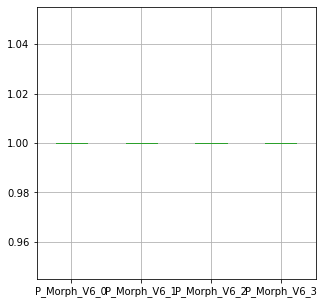

In [93]:
fig = plt.figure(figsize = (5,5))
df3_t1.boxplot()

<AxesSubplot:>

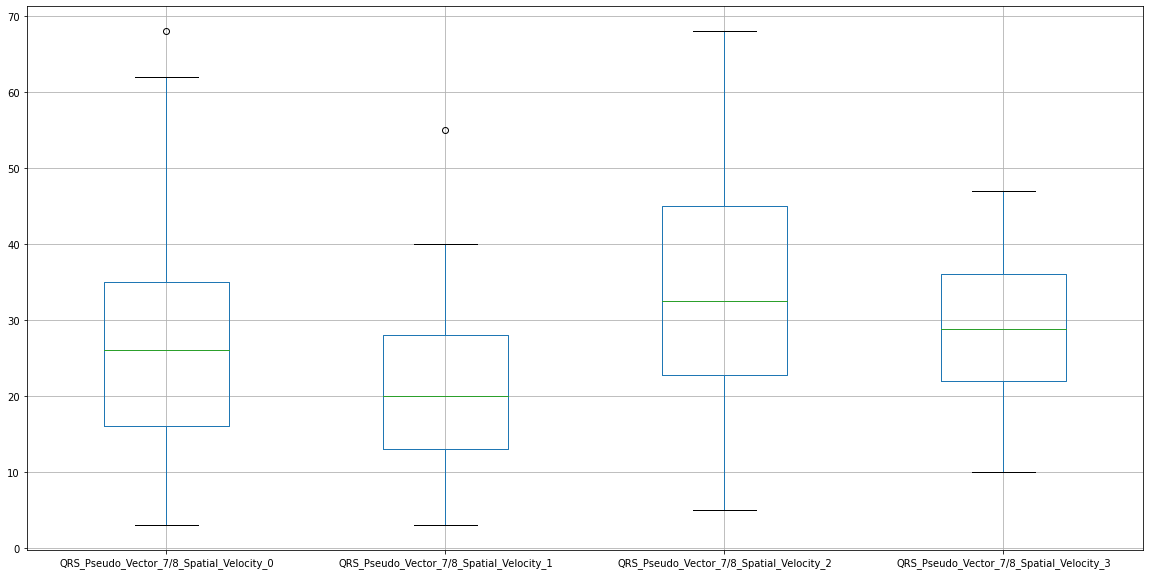

In [94]:
fig = plt.figure(figsize = (20,10))
df4_t1.boxplot()

<AxesSubplot:>

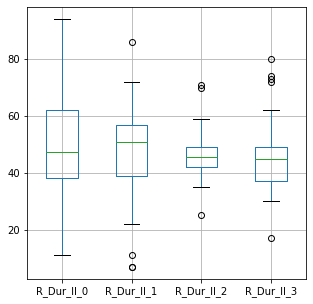

In [95]:
fig = plt.figure(figsize = (5,5))
df5_t1.boxplot()

<AxesSubplot:>

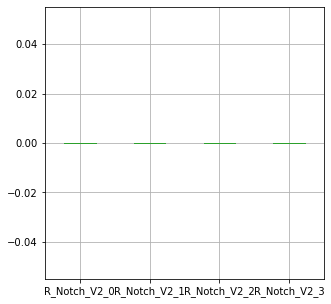

In [96]:
fig = plt.figure(figsize = (5,5))
df6_t1.boxplot()

<AxesSubplot:>

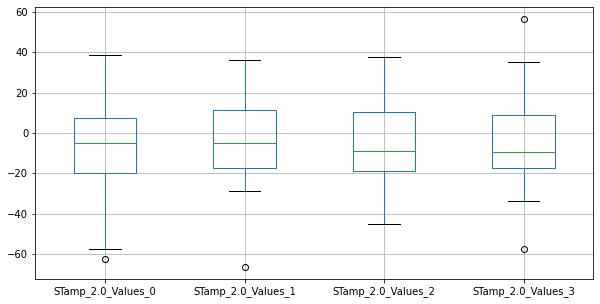

In [97]:
fig = plt.figure(figsize = (10,5))
df7_t1.boxplot()

<AxesSubplot:>

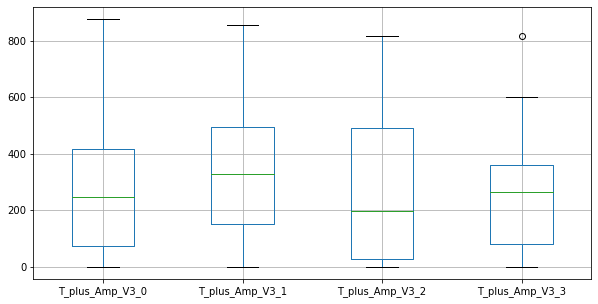

In [98]:
fig = plt.figure(figsize = (10,5))
df8_t1.boxplot()

<AxesSubplot:>

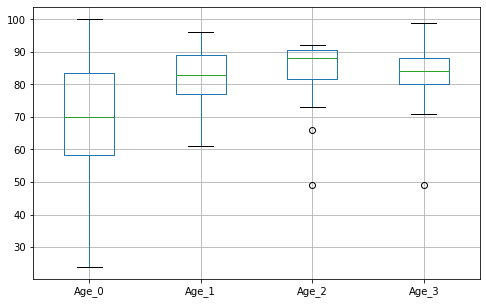

In [99]:
fig = plt.figure(figsize = (8,5))
df9_t1.boxplot()

In [100]:
sub1.Label.value_counts()

0.0    82
1.0    29
3.0    29
2.0    28
Name: Label, dtype: int64

In [101]:
#create subsets of zero values
sub1_0_1 = sub1[sub1['Label'] == 0].head(29)
sub1_0_2 = sub1[sub1['Label'] == 0].iloc[29:57,:]
sub1_0_3 = sub1[sub1['Label'] == 0].tail(29)

#create final subsets
sub1_1_t = sub1[sub1['Label'] != 0]
sub11 = pd.concat([sub1_0_1, sub1_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub12 = pd.concat([sub1_0_2, sub1_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub13 = pd.concat([sub1_0_3, sub1_1_t], axis = 0).reset_index().drop("index", axis = 1)

In [102]:
#Separating values for sub11
X_sub11 = sub11.iloc[:,:-1]
Y_sub11 = sub11.iloc[:,-1]

#Separating values for sub12
X_sub12 = sub12.iloc[:,:-1]
Y_sub12 = sub12.iloc[:,-1]

#Separating values for sub13
X_sub13 = sub13.iloc[:,:-1]
Y_sub13 = sub13.iloc[:,-1]

## *Random Forest*

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# define model
model = RandomForestClassifier()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

# define grid
grid = dict()
grid['criterion'] = ["entropy","gini"]
grid['max_depth'] = [i for i in range(1,25)]

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, Y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [104]:
RF_model11 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [105]:
RF_model12 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [106]:
RF_model13 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [107]:
#Training sub11 on the model
RF_model11.fit(X_sub11,Y_sub11)

#Training sub12 on the model
RF_model12.fit(X_sub12,Y_sub12)

#Training sub13 on the model
RF_model13.fit(X_sub13,Y_sub13)

RandomForestClassifier(max_depth=10, random_state=0)

In [110]:
#predict sub11 the probability results
y_rf11 = RF_model11.predict_proba(X_valid_f)

#predict sub12 the probability results
y_rf12 = RF_model12.predict_proba(X_valid_f)

#predict sub13 the probability results
y_rf13 = RF_model13.predict_proba(X_valid_f)

In [111]:
#Finalization
RF_data = {"probs_mean_sub11": y_rf11.mean(axis = 0) , 
      "probs_mean_sub12": y_rf12.mean(axis = 0),
      "probs_mean_sub13": y_rf13.mean(axis = 0)}

RF1 = pd.DataFrame(RF_data, index = ["class0", "class1", "class2", "class3"])
RF1

,probs_mean_sub11,probs_mean_sub12,probs_mean_sub13
class0,0.360882,0.366795,0.364070
class1,0.241978,0.248487,0.241613
class2,0.177474,0.170509,0.189340
class3,0.219666,0.214210,0.204977


In [108]:
#predict sub11 the results
yr_rf11 = RF_model11.predict(X_valid_f)

#predict sub12 the results
yr_rf12 = RF_model12.predict(X_valid_f)

#predict sub13 the results
yr_rf13 = RF_model13.predict(X_valid_f)

In [303]:
#Accuracy Score
acc_score11 = accuracy_score(y_valid_f,yr_rf11)
acc_score12 = accuracy_score(y_valid_f,yr_rf12)
acc_score13 = accuracy_score(y_valid_f,yr_rf13)

#Precicion Score (Sensitivity)
pr_score11 = precision_score(y_valid_f,yr_rf11, average = "macro")
pr_score12 = precision_score(y_valid_f,yr_rf12, average = "macro")
pr_score13 = precision_score(y_valid_f,yr_rf13, average = "macro")

#Recall Score (Speceficity)
re_score11 = recall_score(y_valid_f,yr_rf11, average = "macro")
re_score12 = recall_score(y_valid_f,yr_rf12, average = "macro")
re_score13 = recall_score(y_valid_f,yr_rf13, average = "macro")

#F1-Score
f1_score11 = recall_score(y_valid_f,yr_rf11, average = "macro")
f1_score12 = recall_score(y_valid_f,yr_rf12, average = "macro")
f1_score13 = recall_score(y_valid_f,yr_rf13, average = "macro")

#Finalization
RF_data1 = {"acc_score": [acc_score11,acc_score12,acc_score13] , 
      "pr_score": [pr_score11,pr_score12,pr_score13],
      "recall_score": [re_score11,re_score12,re_score13], "f1-score" : [f1_score11,f1_score12,f1_score13]}

RF1 = pd.DataFrame(RF_data1, index = ["subset11", "subset12", "subset13"])
RF1

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset11,0.552817,0.308012,0.232485,0.232485
subset12,0.556338,0.295708,0.228445,0.228445
subset13,0.559859,0.300813,0.229474,0.229474


## *Logistic Regression*

In [116]:
from sklearn.linear_model import LogisticRegression
LR_model11 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [117]:
LR_model12 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [118]:
LR_model13 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [119]:
#Training sub11 on the model
LR_model11.fit(X_sub11,Y_sub11)

#Training sub12 on the model
LR_model12.fit(X_sub12,Y_sub12)

#Training sub13 on the model
LR_model13.fit(X_sub13,Y_sub13)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.2, penalty='elasticnet', solver='saga')

In [120]:
#predict sub11 the results
y_lr11 = LR_model11.predict_proba(X_valid_f)

#predict sub12 the results
y_lr12 = LR_model12.predict_proba(X_valid_f)

#predict sub13 the results
y_lr13 = LR_model13.predict_proba(X_valid_f)

In [121]:
#Finalization
LR_data = {"probs_mean_sub11": y_lr11.mean(axis = 0) , 
      "probs_mean_sub12": y_lr12.mean(axis = 0),
      "probs_mean_sub13": y_lr13.mean(axis = 0)}

LR1 = pd.DataFrame(LR_data, index = ["class0", "class1", "class2", "class3"])
LR1

,probs_mean_sub11,probs_mean_sub12,probs_mean_sub13
class0,0.289120,0.268102,0.298366
class1,0.247555,0.251622,0.242986
class2,0.229961,0.235970,0.226493
class3,0.233364,0.244306,0.232155


In [122]:
#predict sub11 the results
yr_lr11 = LR_model11.predict(X_valid_f)

#predict sub12 the results
yr_lr12 = LR_model12.predict(X_valid_f)

#predict sub13 the results
yr_lr13 = LR_model13.predict(X_valid_f)

In [302]:
#Accuracy Score
acc_score11 = accuracy_score(y_valid_f,yr_lr11)
acc_score12 = accuracy_score(y_valid_f,yr_lr12)
acc_score13 = accuracy_score(y_valid_f,yr_lr13)

#Precicion Score (Sensitivity)
pr_score11 = precision_score(y_valid_f,yr_lr11, average = "macro")
pr_score12 = precision_score(y_valid_f,yr_lr12, average = "macro")
pr_score13 = precision_score(y_valid_f,yr_lr13, average = "macro")

#Recall Score (Speceficity)
re_score11 = recall_score(y_valid_f,yr_lr11, average = "macro")
re_score12 = recall_score(y_valid_f,yr_lr12, average = "macro")
re_score13 = recall_score(y_valid_f,yr_lr13, average = "macro")

#F1-Score
f1_score11 = recall_score(y_valid_f,yr_lr11, average = "macro")
f1_score12 = recall_score(y_valid_f,yr_lr12, average = "macro")
f1_score13 = recall_score(y_valid_f,yr_lr13, average = "macro")

#Finalization
LR_data1 = {"acc_score": [acc_score11,acc_score12,acc_score13] , 
      "pr_score": [pr_score11,pr_score12,pr_score13],
      "recall_score": [re_score11,re_score12,re_score13], "f1-score" : [f1_score11,f1_score12,f1_score13]}

LR1 = pd.DataFrame(LR_data1, index = ["subset11", "subset12", "subset13"])
LR1

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset11,0.485915,0.301773,0.223075,0.223075
subset12,0.380282,0.290679,0.197280,0.197280
subset13,0.538732,0.309686,0.238507,0.238507


# *Decision Tree*

In [124]:
from sklearn.tree import DecisionTreeClassifier

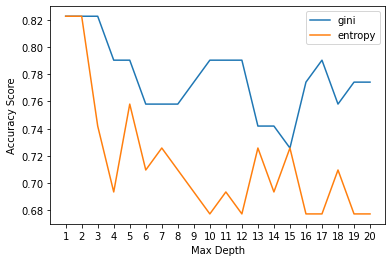

In [ ]:

from sklearn.metrics import accuracy_score

max_depth = []
acc_gini = []
acc_entropy = []

for i in range(1,21):
  dtree = DecisionTreeClassifier(criterion = "gini", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_gini.append(accuracy_score(Y_test,pred))

  dtree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_entropy.append(accuracy_score(Y_test,pred))

  max_depth.append(i)

df = pd.DataFrame({"acc_gini" : pd.Series(acc_gini),
                   "acc_entropy" : pd.Series(acc_entropy), 
                   "max_depth" : pd.Series(max_depth)})

plt.plot("max_depth", "acc_gini", data = df, label = "gini")
plt.plot("max_depth", "acc_entropy", data = df, label = "entropy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.xticks([j for j in range(1,21)])
plt.legend()
plt.show()

In [125]:
DT_model11 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [126]:
DT_model12 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [127]:
DT_model13 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [128]:
#Training sub11 on the model
DT_model11.fit(X_sub11,Y_sub11)

#Training sub12 on the model
DT_model12.fit(X_sub12,Y_sub12)

#Training sub13 on the model
DT_model13.fit(X_sub13,Y_sub13)

DecisionTreeClassifier(max_depth=3)

In [129]:
#predict sub11 the results
y_dt11 = DT_model11.predict_proba(X_valid_f)

#predict sub12 the results
y_dt12 = DT_model12.predict_proba(X_valid_f)

#predict sub13 the results
y_dt13 = DT_model13.predict_proba(X_valid_f)

In [130]:
#Finalization
DT_data = {"probs_mean_sub11": y_dt11.mean(axis = 0) , 
      "probs_mean_sub12": y_dt12.mean(axis = 0),
      "probs_mean_sub13": y_dt13.mean(axis = 0)}

DT1 = pd.DataFrame(DT_data, index = ["class0", "class1", "class2", "class3"])
DT1

,probs_mean_sub11,probs_mean_sub12,probs_mean_sub13
class0,0.395432,0.443518,0.423067
class1,0.263181,0.225330,0.219730
class2,0.146545,0.159881,0.152743
class3,0.194842,0.171270,0.204460


In [131]:
#predict sub11 the results
yr_dt11 = DT_model11.predict(X_valid_f)

#predict sub12 the results
yr_dt12 = DT_model12.predict(X_valid_f)

#predict sub13 the results
yr_dt13 = DT_model13.predict(X_valid_f)

In [301]:
#Accuracy Score
acc_score11 = accuracy_score(y_valid_f,yr_dt11)
acc_score12 = accuracy_score(y_valid_f,yr_dt12)
acc_score13 = accuracy_score(y_valid_f,yr_dt13)

#Precicion Score (Sensitivity)
pr_score11 = precision_score(y_valid_f,yr_dt11, average = "macro")
pr_score12 = precision_score(y_valid_f,yr_dt12, average = "macro")
pr_score13 = precision_score(y_valid_f,yr_dt13, average = "macro")

#Recall Score (Speceficity)
re_score11 = recall_score(y_valid_f,yr_dt11, average = "macro")
re_score12 = recall_score(y_valid_f,yr_dt12, average = "macro")
re_score13 = recall_score(y_valid_f,yr_dt13, average = "macro")

#F1-Score
f1_score11 = recall_score(y_valid_f,yr_dt11, average = "macro")
f1_score12 = recall_score(y_valid_f,yr_dt12, average = "macro")
f1_score13 = recall_score(y_valid_f,yr_dt13, average = "macro")

#Finalization
DT_data1 = {"acc_score": [acc_score11,acc_score12,acc_score13] , 
      "pr_score": [pr_score11,pr_score12,pr_score13],
      "recall_score": [re_score11,re_score12,re_score13], "f1-score" : [f1_score11,f1_score12,f1_score13]}

DT1 = pd.DataFrame(DT_data1, index = ["subset11", "subset12", "subset13"])
DT1

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset11,0.492958,0.302794,0.225133,0.225133
subset12,0.552817,0.304056,0.257829,0.257829
subset13,0.503521,0.307940,0.228219,0.228219


# ***Subset2***

In [133]:
sub2_1 = sub2[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age','Label']]
sub2_1

,P_Area_V1,P_Area_V4,P_Morph_V6,QRS_Pseudo_Vector_7/8_Spatial_Velocity,R_Dur_II,R_Notch_V2,STamp_2.0_Values,T_plus_Amp_V3,Sex,Age,Label
451,-105.0,62.0,1.0,15.0,55.0,0.0,-1.25,358.0,1.0,90.0,0.0
466,-146.0,-12.0,1.0,17.0,66.0,0.0,-47.50,210.0,1.0,49.0,0.0
416,35.0,28.0,1.0,25.0,43.8,0.0,-1.25,475.0,1.0,85.0,0.0
219,-121.4,-56.0,1.0,23.0,76.0,0.0,6.25,293.0,1.0,61.0,0.0
148,-16.0,-10.0,1.0,32.0,52.8,0.0,22.00,876.0,1.0,69.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
827,-74.0,-37.0,1.0,32.0,36.0,0.0,8.75,401.0,0.0,88.0,1.0
828,54.0,-163.0,1.0,21.0,30.0,0.0,26.25,384.0,0.0,88.0,1.0
829,5.8,-137.8,1.0,28.0,35.0,0.0,-8.75,318.0,0.0,88.0,1.0
832,0.0,-1.0,1.0,26.0,80.0,0.0,-17.50,303.0,1.0,86.0,1.0


In [134]:
sub2_1_0 = sub2_1[sub2_1["Label"] == 0]
sub2_1_1 = sub2_1[sub2_1["Label"] == 1]

In [135]:
data_morto_12 = sub2_1_1.head(29).replace({"Label" : 1}, 1)
data_morto_22= sub2_1_1.iloc[29:57,:].replace({"Label" : 1}, 2)
data_morto_32 = sub2_1_1.tail(29).replace({"Label" : 1}, 3)

In [136]:
sub2 = pd.concat([sub2_1_0,data_morto_12,data_morto_22,data_morto_32], axis = 0).reset_index().drop("index", axis = 1)

In [137]:
#Feature 1
df1_02 = sub2[sub2["Label"] == 0].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_0"})
df1_12 = sub2[sub2["Label"] == 1].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_1"})
df1_22 = sub2[sub2["Label"] == 2].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_2"})
df1_32 = sub2[sub2["Label"] == 3].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_3"})
df1_t2 = pd.concat([df1_02,df1_12,df1_22,df1_32], axis = 1)

#Feature 2
df2_02 = sub2[sub2["Label"] == 0].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_0"})
df2_12 = sub2[sub2["Label"] == 1].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_1"})
df2_22 = sub2[sub2["Label"] == 2].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_2"})
df2_32 = sub2[sub2["Label"] == 3].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_3"})
df2_t2 = pd.concat([df2_02,df2_12,df2_22,df2_32], axis = 1)

#Feature 3
df3_02 = sub2[sub2["Label"] == 0].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_0"})
df3_12 = sub2[sub2["Label"] == 1].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_1"})
df3_22 = sub2[sub2["Label"] == 2].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_2"})
df3_32 = sub2[sub2["Label"] == 3].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_3"})
df3_t2 = pd.concat([df3_02,df3_12,df3_22,df3_32], axis = 1)

#Feature 4
df4_02 = sub2[sub2["Label"] == 0].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_0"})
df4_12 = sub2[sub2["Label"] == 1].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_1"})
df4_22 = sub2[sub2["Label"] == 2].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_2"})
df4_32 = sub2[sub2["Label"] == 3].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_3"})
df4_t2 = pd.concat([df4_02,df4_12,df4_22,df4_32], axis = 1)
#Feature 5
df5_02 = sub2[sub2["Label"] == 0].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_0"})
df5_12 = sub2[sub2["Label"] == 1].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_1"})
df5_22 = sub2[sub2["Label"] == 2].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_2"})
df5_32 = sub2[sub2["Label"] == 3].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_3"})
df5_t2 = pd.concat([df5_02,df5_12,df5_22,df5_32], axis = 1)

#Feature 6
df6_02 = sub2[sub2["Label"] == 0].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_0"})
df6_12 = sub2[sub2["Label"] == 1].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_1"})
df6_22 = sub2[sub2["Label"] == 2].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_2"})
df6_32 = sub2[sub2["Label"] == 3].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_3"})
df6_t2 = pd.concat([df6_02,df6_12,df6_22,df6_32], axis = 1)

#Feature 7
df7_02 = sub2[sub2["Label"] == 0].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_0"})
df7_12 = sub2[sub2["Label"] == 1].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_1"})
df7_22 = sub2[sub2["Label"] == 2].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_2"})
df7_32 = sub2[sub2["Label"] == 3].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_3"})
df7_t2 = pd.concat([df7_02,df7_12,df7_22,df7_32], axis = 1)

#Feature 8
df8_02 = sub2[sub2["Label"] == 0].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_0"})
df8_12 = sub2[sub2["Label"] == 1].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_1"})
df8_22 = sub2[sub2["Label"] == 2].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_2"})
df8_32 = sub2[sub2["Label"] == 3].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_3"})
df8_t2 = pd.concat([df8_02,df8_12,df8_22,df8_32], axis = 1)

#Feature 9
df9_02 = sub2[sub2["Label"] == 0].iloc[:,[9]].rename(columns = {"Age" : "Age_0"})
df9_12 = sub2[sub2["Label"] == 1].iloc[:,[9]].rename(columns = {"Age" : "Age_1"})
df9_22 = sub2[sub2["Label"] == 2].iloc[:,[9]].rename(columns = {"Age" : "Age_2"})
df9_32 = sub2[sub2["Label"] == 3].iloc[:,[9]].rename(columns = {"Age" : "Age_3"})
df9_t2 = pd.concat([df9_02,df9_12,df9_22,df9_32], axis = 1)

<AxesSubplot:>

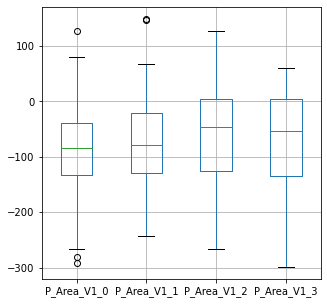

In [138]:
fig = plt.figure(figsize = (5,5))
df1_t2.boxplot()

<AxesSubplot:>

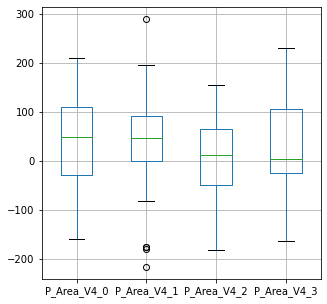

In [139]:
fig = plt.figure(figsize = (5,5))
df2_t2.boxplot()

<AxesSubplot:>

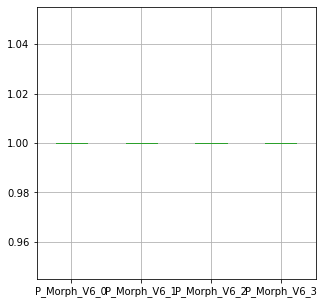

In [140]:
fig = plt.figure(figsize = (5,5))
df3_t2.boxplot()

<AxesSubplot:>

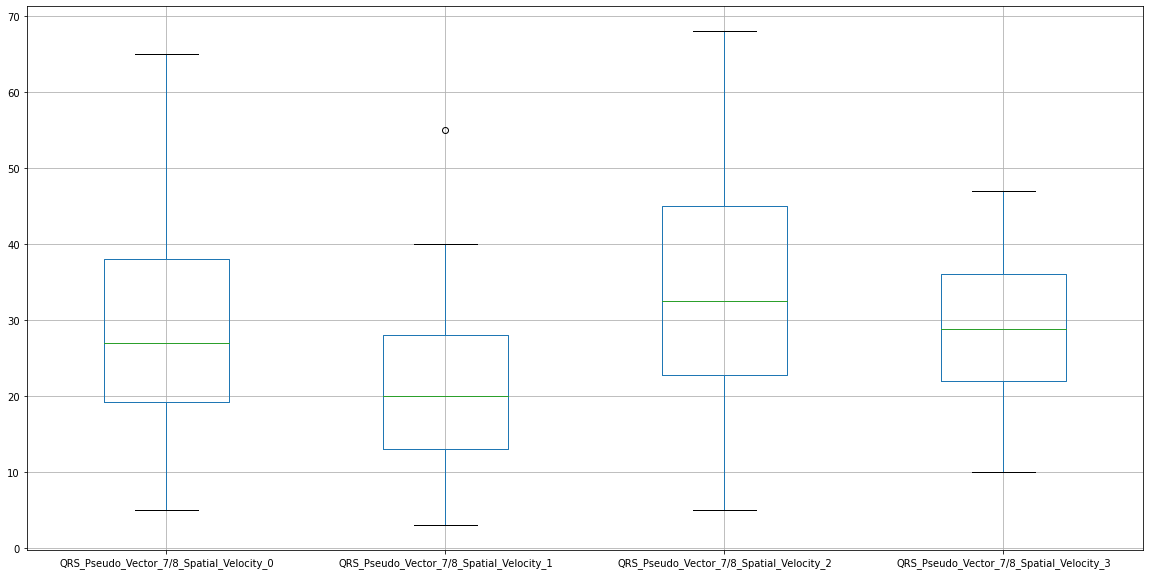

In [141]:
fig = plt.figure(figsize = (20,10))
df4_t2.boxplot()

<AxesSubplot:>

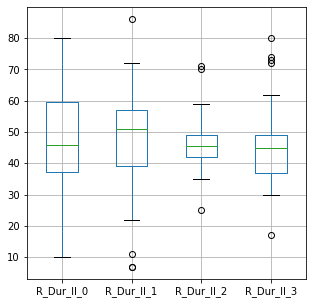

In [142]:
fig = plt.figure(figsize = (5,5))
df5_t2.boxplot()

<AxesSubplot:>

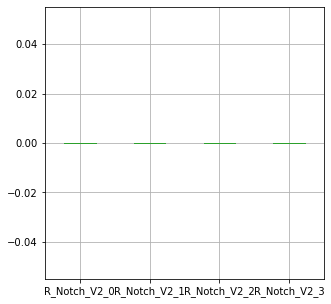

In [143]:
fig = plt.figure(figsize = (5,5))
df6_t2.boxplot()

<AxesSubplot:>

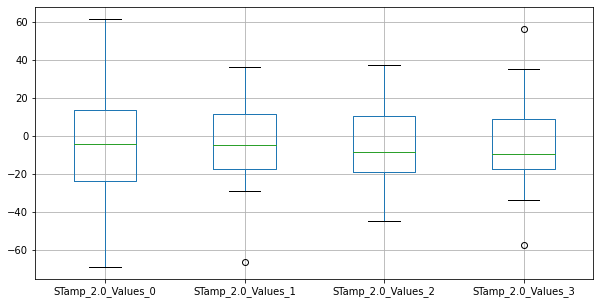

In [144]:
fig = plt.figure(figsize = (10,5))
df7_t2.boxplot()

<AxesSubplot:>

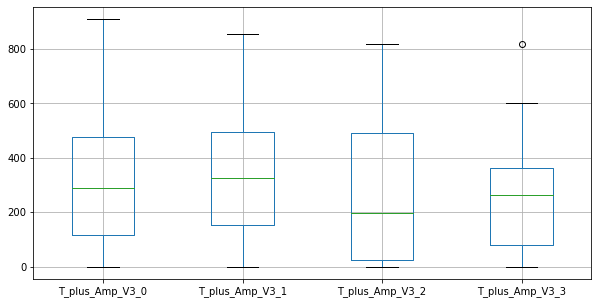

In [145]:
fig = plt.figure(figsize = (10,5))
df8_t2.boxplot()

<AxesSubplot:>

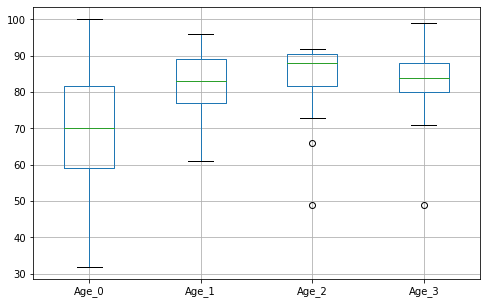

In [146]:
fig = plt.figure(figsize = (8,5))
df9_t2.boxplot()

In [147]:
#create subsets of zero values
sub2_0_1 = sub2[sub2['Label'] == 0].head(29)
sub2_0_2 = sub2[sub2['Label'] == 0].iloc[29:57,:]
sub2_0_3 = sub2[sub2['Label'] == 0].tail(29)

#create final subsets
sub2_1_t = sub2[sub2['Label'] != 0]
sub21 = pd.concat([sub2_0_1, sub2_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub22 = pd.concat([sub2_0_2, sub2_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub23 = pd.concat([sub2_0_3, sub2_1_t], axis = 0).reset_index().drop("index", axis = 1)

In [148]:
#Separating values for sub21
X_sub21 = sub21.iloc[:,:-1]
Y_sub21 = sub21.iloc[:,-1]

#Separating values for sub22
X_sub22 = sub22.iloc[:,:-1]
Y_sub22 = sub22.iloc[:,-1]

#Separating values for sub23
X_sub23 = sub23.iloc[:,:-1]
Y_sub23 = sub23.iloc[:,-1]

## *Random Forest*

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# define model
model = RandomForestClassifier()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

# define grid
grid = dict()
grid['criterion'] = ["entropy","gini"]
grid['max_depth'] = [i for i in range(1,25)]

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, Y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [150]:
RF_model21 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [151]:
RF_model22 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [152]:
RF_model23 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [153]:
#Training sub21 on the model
RF_model21.fit(X_sub21,Y_sub21)

#Training sub22 on the model
RF_model22.fit(X_sub22,Y_sub22)

#Training sub23 on the model
RF_model23.fit(X_sub23,Y_sub23)

RandomForestClassifier(max_depth=10, random_state=0)

In [154]:
#predict sub21 the results
y_rf21 = RF_model21.predict_proba(X_valid_f)

#predict sub22 the results
y_rf22 = RF_model22.predict_proba(X_valid_f)

#predict sub23 the results
y_rf23 = RF_model23.predict_proba(X_valid_f)

In [155]:
#Finalization
RF_data = {"probs_mean_sub21": y_rf21.mean(axis = 0) , 
      "probs_mean_sub22": y_rf22.mean(axis = 0),
      "probs_mean_sub23": y_rf23.mean(axis = 0)}

RF2 = pd.DataFrame(RF_data, index = ["class0", "class1", "class2", "class3"])
RF2

,probs_mean_sub21,probs_mean_sub22,probs_mean_sub23
class0,0.361480,0.365287,0.329647
class1,0.247003,0.255136,0.269166
class2,0.177807,0.172699,0.183579
class3,0.213709,0.206877,0.217607


In [156]:
#predict sub11 the results
yr_rf21 = RF_model21.predict(X_valid_f)

#predict sub12 the results
yr_rf22 = RF_model22.predict(X_valid_f)

#predict sub13 the results
yr_rf23 = RF_model23.predict(X_valid_f)

In [300]:
#Accuracy Score
acc_score21 = accuracy_score(y_valid_f,yr_rf21)
acc_score22 = accuracy_score(y_valid_f,yr_rf22)
acc_score23 = accuracy_score(y_valid_f,yr_rf23)

#Precicion Score (Sensitivity)
pr_score21 = precision_score(y_valid_f,yr_rf21, average = "macro")
pr_score22 = precision_score(y_valid_f,yr_rf22, average = "macro")
pr_score23 = precision_score(y_valid_f,yr_rf23, average = "macro")

#Recall Score (Speceficity)
re_score21 = recall_score(y_valid_f,yr_rf21, average = "macro")
re_score22 = recall_score(y_valid_f,yr_rf22, average = "macro")
re_score23 = recall_score(y_valid_f,yr_rf23, average = "macro")

#F1-Score
f1_score21 = recall_score(y_valid_f,yr_rf21, average = "macro")
f1_score22 = recall_score(y_valid_f,yr_rf22, average = "macro")
f1_score23 = recall_score(y_valid_f,yr_rf23, average = "macro")

#Finalization
RF_data2 = {"acc_score": [acc_score21,acc_score22,acc_score23] , 
      "pr_score": [pr_score21,pr_score22,pr_score23],
      "recall_score": [re_score21,re_score22,re_score23], "f1-score" : [f1_score21,f1_score22,f1_score23]}

RF2 = pd.DataFrame(RF_data2, index = ["subset21", "subset22", "subset23"])
RF2

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset21,0.580986,0.312951,0.245784,0.245784
subset22,0.549296,0.293973,0.226388,0.226388
subset23,0.475352,0.283644,0.209851,0.209851


## *Logistic Regression*

In [158]:
from sklearn.linear_model import LogisticRegression
LR_model21 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [159]:
LR_model22 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [160]:
LR_model23 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [161]:
#Training sub21 on the model
LR_model21.fit(X_sub21,Y_sub21)

#Training sub22 on the model
LR_model22.fit(X_sub22,Y_sub22)

#Training sub23 on the model
LR_model23.fit(X_sub23,Y_sub23)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.2, penalty='elasticnet', solver='saga')

In [162]:
#predict sub21 the results
y_lr21 = LR_model21.predict_proba(X_valid_f)

#predict sub22 the results
y_lr22 = LR_model22.predict_proba(X_valid_f)

#predict sub23 the results
y_lr23 = LR_model23.predict_proba(X_valid_f)

In [163]:
#Finalization
LR_data = {"probs_mean_sub21": y_lr21.mean(axis = 0) , 
      "probs_mean_sub22": y_lr22.mean(axis = 0),
      "probs_mean_sub23": y_lr23.mean(axis = 0)}

LR2 = pd.DataFrame(LR_data, index = ["class0", "class1", "class2", "class3"])
LR2

,probs_mean_sub21,probs_mean_sub22,probs_mean_sub23
class0,0.299186,0.254837,0.283923
class1,0.241031,0.258701,0.257122
class2,0.225480,0.239281,0.222792
class3,0.234304,0.247181,0.236163


In [164]:
#predict sub11 the results
yr_lr21 = LR_model21.predict(X_valid_f)

#predict sub12 the results
yr_lr22 = LR_model22.predict(X_valid_f)

#predict sub13 the results
yr_lr23 = LR_model23.predict(X_valid_f)

In [299]:
#Accuracy Score
acc_score21 = accuracy_score(y_valid_f,yr_lr21)
acc_score22 = accuracy_score(y_valid_f,yr_lr22)
acc_score23 = accuracy_score(y_valid_f,yr_lr23)

#Precicion Score (Sensitivity)
pr_score21 = precision_score(y_valid_f,yr_lr21, average = "macro")
pr_score22 = precision_score(y_valid_f,yr_lr22, average = "macro")
pr_score23 = precision_score(y_valid_f,yr_lr23, average = "macro")

#Recall Score (Speceficity)
re_score21 = recall_score(y_valid_f,yr_lr21, average = "macro")
re_score22 = recall_score(y_valid_f,yr_lr22, average = "macro")
re_score23 = recall_score(y_valid_f,yr_lr23, average = "macro")

#F1-Score
f1_score21 = recall_score(y_valid_f,yr_lr21, average = "macro")
f1_score22 = recall_score(y_valid_f,yr_lr22, average = "macro")
f1_score23 = recall_score(y_valid_f,yr_lr23, average = "macro")


#Finalization
LR_data2 = {"acc_score": [acc_score21,acc_score22,acc_score23] , 
      "pr_score": [pr_score21,pr_score22,pr_score23],
      "recall_score": [re_score21,re_score22,re_score23], "f1-score" : [f1_score21,f1_score22,f1_score23]}

LR2 = pd.DataFrame(LR_data2, index = ["subset21", "subset22", "subset23"])
LR2

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset21,0.471831,0.291468,0.203754,0.203754
subset22,0.320423,0.263156,0.154446,0.154446
subset23,0.436620,0.281043,0.208672,0.208672


# *Decision Tree*

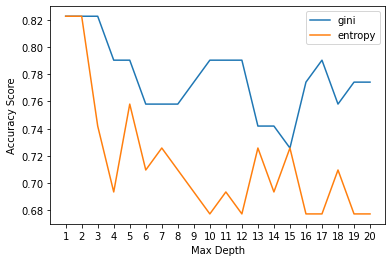

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depth = []
acc_gini = []
acc_entropy = []

for i in range(1,21):
  dtree = DecisionTreeClassifier(criterion = "gini", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_gini.append(accuracy_score(Y_test,pred))

  dtree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_entropy.append(accuracy_score(Y_test,pred))

  max_depth.append(i)

df = pd.DataFrame({"acc_gini" : pd.Series(acc_gini),
                   "acc_entropy" : pd.Series(acc_entropy), 
                   "max_depth" : pd.Series(max_depth)})

plt.plot("max_depth", "acc_gini", data = df, label = "gini")
plt.plot("max_depth", "acc_entropy", data = df, label = "entropy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.xticks([j for j in range(1,21)])
plt.legend()
plt.show()

In [166]:
DT_model21 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [167]:
DT_model22 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [168]:
DT_model23 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [169]:
#Training sub21 on the model
DT_model21.fit(X_sub21,Y_sub21)

#Training sub22 on the model
DT_model22.fit(X_sub22,Y_sub22)

#Training sub13 on the model
DT_model23.fit(X_sub23,Y_sub23)

DecisionTreeClassifier(max_depth=3)

In [170]:
#predict sub21 the results
y_dt21 = DT_model11.predict_proba(X_valid_f)

#predict sub22 the results
y_dt22 = DT_model22.predict_proba(X_valid_f)

#predict sub23 the results
y_dt23 = DT_model23.predict_proba(X_valid_f)

In [171]:
#Finalization
DT_data = {"probs_mean_sub21": y_dt21.mean(axis = 0) , 
      "probs_mean_sub22": y_dt22.mean(axis = 0),
      "probs_mean_sub23": y_dt23.mean(axis = 0)}

DT2 = pd.DataFrame(DT_data, index = ["class0", "class1", "class2", "class3"])
DT2

,probs_mean_sub21,probs_mean_sub22,probs_mean_sub23
class0,0.395432,0.460915,0.343774
class1,0.263181,0.207081,0.272297
class2,0.146545,0.155111,0.178970
class3,0.194842,0.176892,0.204959


In [172]:
#predict sub11 the results
yr_dt21 = DT_model21.predict(X_valid_f)

#predict sub12 the results
yr_dt22 = DT_model22.predict(X_valid_f)

#predict sub13 the results
yr_dt23 = DT_model23.predict(X_valid_f)

In [298]:
#Accuracy Score
acc_score21 = accuracy_score(y_valid_f,yr_dt21)
acc_score22 = accuracy_score(y_valid_f,yr_dt22)
acc_score23 = accuracy_score(y_valid_f,yr_dt23)

#Precicion Score (Sensitivity)
pr_score21 = precision_score(y_valid_f,yr_dt21, average = "macro")
pr_score22 = precision_score(y_valid_f,yr_dt22, average = "macro")
pr_score23 = precision_score(y_valid_f,yr_dt23, average = "macro")

#Recall Score (Speceficity)
re_score21 = recall_score(y_valid_f,yr_dt21, average = "macro")
re_score22 = recall_score(y_valid_f,yr_dt22, average = "macro")
re_score23 = recall_score(y_valid_f,yr_dt23, average = "macro")

#F1-Score
f1_score21 = recall_score(y_valid_f,yr_dt21, average = "macro")
f1_score22 = recall_score(y_valid_f,yr_dt22, average = "macro")
f1_score23 = recall_score(y_valid_f,yr_dt23, average = "macro")

#Finalization
DT_data2 = {"acc_score": [acc_score21,acc_score22,acc_score23] , 
      "pr_score": [pr_score21,pr_score22,pr_score23],
      "recall_score": [re_score21,re_score22,re_score23], "f1-score" : [f1_score21,f1_score22,f1_score23]}

DT2 = pd.DataFrame(DT_data2, index = ["subset21", "subset22", "subset23"])
DT2

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset21,0.433099,0.285935,0.207643,0.207643
subset22,0.485915,0.299873,0.228144,0.228144
subset23,0.644366,0.266559,0.218684,0.218684


# ***Subset3***

In [174]:
sub3_1 = sub3[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age','Label']]
sub3_1

,P_Area_V1,P_Area_V4,P_Morph_V6,QRS_Pseudo_Vector_7/8_Spatial_Velocity,R_Dur_II,R_Notch_V2,STamp_2.0_Values,T_plus_Amp_V3,Sex,Age,Label
225,-38.0,189.0,1.0,51.0,55.0,0.0,-23.75,485.0,1.0,33.0,0.0
630,-56.0,48.0,1.0,13.0,66.0,0.0,-38.75,403.0,0.0,71.0,0.0
719,-152.0,13.0,1.0,17.0,43.0,0.0,-16.25,479.0,1.0,69.0,0.0
493,-96.0,123.0,1.0,18.0,80.0,0.0,-60.00,278.0,1.0,73.0,0.0
654,-72.0,-78.0,1.0,36.0,27.0,0.0,9.25,236.0,1.0,94.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
827,-74.0,-37.0,1.0,32.0,36.0,0.0,8.75,401.0,0.0,88.0,1.0
828,54.0,-163.0,1.0,21.0,30.0,0.0,26.25,384.0,0.0,88.0,1.0
829,5.8,-137.8,1.0,28.0,35.0,0.0,-8.75,318.0,0.0,88.0,1.0
832,0.0,-1.0,1.0,26.0,80.0,0.0,-17.50,303.0,1.0,86.0,1.0


In [175]:
sub3_1_0 = sub3_1[sub3_1["Label"] == 0]
sub3_1_1 = sub3_1[sub3_1["Label"] == 1]

In [176]:
data_morto_13 = sub3_1_1.head(29).replace({"Label" : 1}, 1)
data_morto_23= sub3_1_1.iloc[29:57,:].replace({"Label" : 1}, 2)
data_morto_33 = sub3_1_1.tail(29).replace({"Label" : 1}, 3)

In [177]:
sub3 = pd.concat([sub3_1_0,data_morto_13,data_morto_23,data_morto_33], axis = 0).reset_index().drop("index", axis = 1)

In [178]:
#Feature 1
df1_03 = sub3[sub3["Label"] == 0].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_0"})
df1_13 = sub3[sub3["Label"] == 1].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_1"})
df1_23 = sub3[sub3["Label"] == 2].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_2"})
df1_33 = sub3[sub3["Label"] == 3].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_3"})
df1_t3 = pd.concat([df1_03,df1_13,df1_23,df1_33], axis = 1)

#Feature 2
df2_03 = sub3[sub3["Label"] == 0].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_0"})
df2_13 = sub3[sub3["Label"] == 1].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_1"})
df2_23 = sub3[sub3["Label"] == 2].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_2"})
df2_33 = sub3[sub3["Label"] == 3].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_3"})
df2_t3 = pd.concat([df2_03,df2_13,df2_23,df2_33], axis = 1)

#Feature 3
df3_03 = sub3[sub3["Label"] == 0].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_0"})
df3_13 = sub3[sub3["Label"] == 1].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_1"})
df3_23 = sub3[sub3["Label"] == 2].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_2"})
df3_33 = sub3[sub3["Label"] == 3].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_3"})
df3_t3 = pd.concat([df3_03,df3_13,df3_23,df3_33], axis = 1)

#Feature 4
df4_03 = sub3[sub3["Label"] == 0].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_0"})
df4_13 = sub3[sub3["Label"] == 1].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_1"})
df4_23 = sub3[sub3["Label"] == 2].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_2"})
df4_33 = sub3[sub3["Label"] == 3].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_3"})
df4_t3 = pd.concat([df4_03,df4_13,df4_23,df4_33], axis = 1)
#Feature 5
df5_03 = sub3[sub3["Label"] == 0].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_0"})
df5_13 = sub3[sub3["Label"] == 1].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_1"})
df5_23 = sub3[sub3["Label"] == 2].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_2"})
df5_33 = sub3[sub3["Label"] == 3].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_3"})
df5_t3 = pd.concat([df5_03,df5_13,df5_23,df5_33], axis = 1)

#Feature 6
df6_03 = sub3[sub3["Label"] == 0].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_0"})
df6_13 = sub3[sub3["Label"] == 1].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_1"})
df6_23 = sub3[sub3["Label"] == 2].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_2"})
df6_33 = sub3[sub3["Label"] == 3].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_3"})
df6_t3 = pd.concat([df6_03,df6_13,df6_23,df6_33], axis = 1)

#Feature 7
df7_03 = sub3[sub3["Label"] == 0].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_0"})
df7_13 = sub3[sub3["Label"] == 1].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_1"})
df7_23 = sub3[sub3["Label"] == 2].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_2"})
df7_33 = sub3[sub3["Label"] == 3].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_3"})
df7_t3 = pd.concat([df7_03,df7_13,df7_23,df7_33], axis = 1)

#Feature 8
df8_03 = sub3[sub3["Label"] == 0].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_0"})
df8_13 = sub3[sub3["Label"] == 1].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_1"})
df8_23 = sub3[sub3["Label"] == 2].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_2"})
df8_33 = sub3[sub3["Label"] == 3].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_3"})
df8_t3 = pd.concat([df8_03,df8_13,df8_23,df8_33], axis = 1)

#Feature 9
df9_03 = sub3[sub3["Label"] == 0].iloc[:,[9]].rename(columns = {"Age" : "Age_0"})
df9_13 = sub3[sub3["Label"] == 1].iloc[:,[9]].rename(columns = {"Age" : "Age_1"})
df9_23 = sub3[sub3["Label"] == 2].iloc[:,[9]].rename(columns = {"Age" : "Age_2"})
df9_33 = sub3[sub3["Label"] == 3].iloc[:,[9]].rename(columns = {"Age" : "Age_3"})
df9_t3 = pd.concat([df9_03,df9_13,df9_23,df9_33], axis = 1)

<AxesSubplot:>

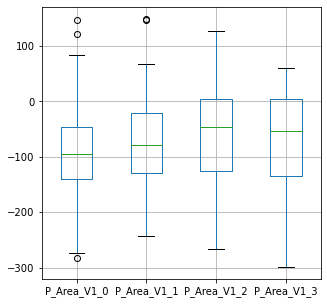

In [179]:
fig = plt.figure(figsize = (5,5))
df1_t3.boxplot()

<AxesSubplot:>

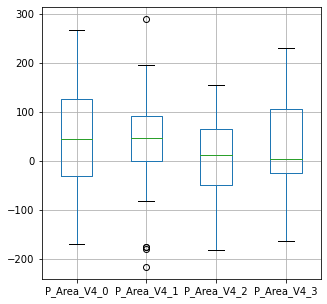

In [180]:
fig = plt.figure(figsize = (5,5))
df2_t3.boxplot()

<AxesSubplot:>

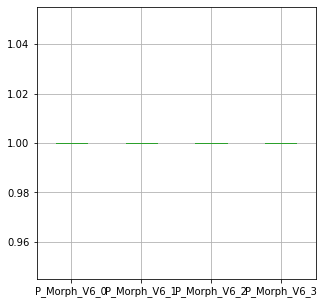

In [181]:
fig = plt.figure(figsize = (5,5))
df3_t3.boxplot()

<AxesSubplot:>

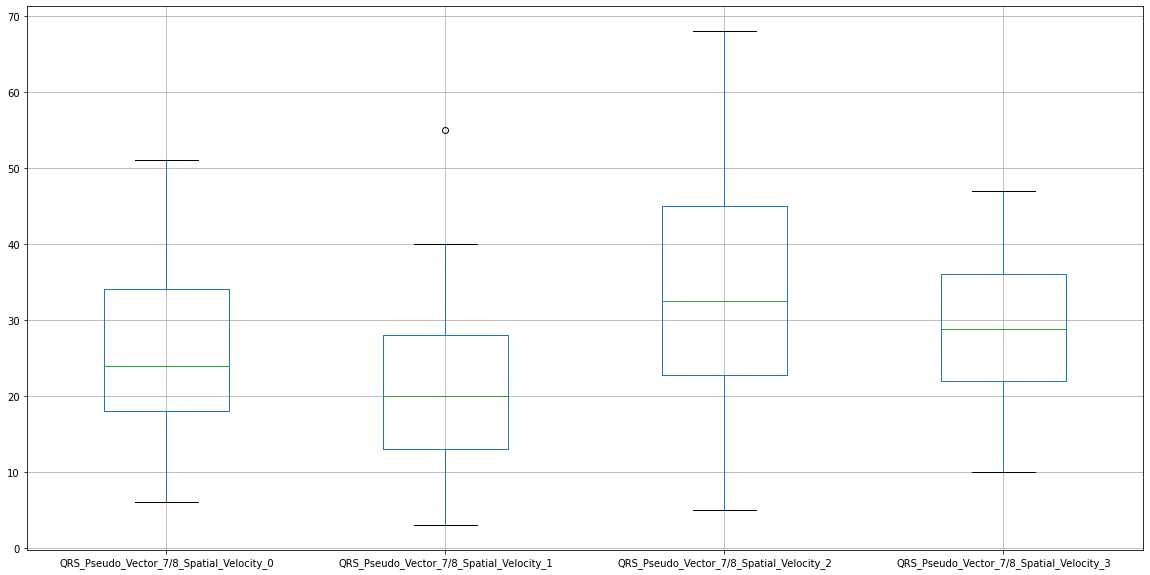

In [182]:
fig = plt.figure(figsize = (20,10))
df4_t3.boxplot()

<AxesSubplot:>

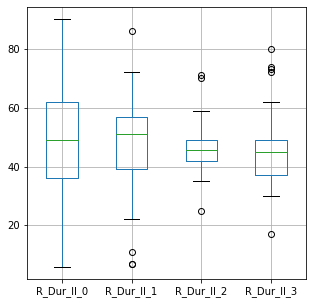

In [183]:
fig = plt.figure(figsize = (5,5))
df5_t3.boxplot()

<AxesSubplot:>

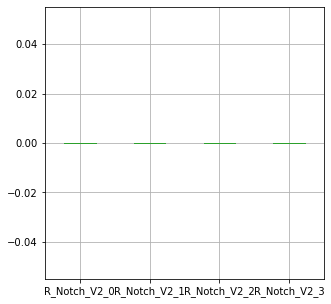

In [184]:
fig = plt.figure(figsize = (5,5))
df6_t3.boxplot()

<AxesSubplot:>

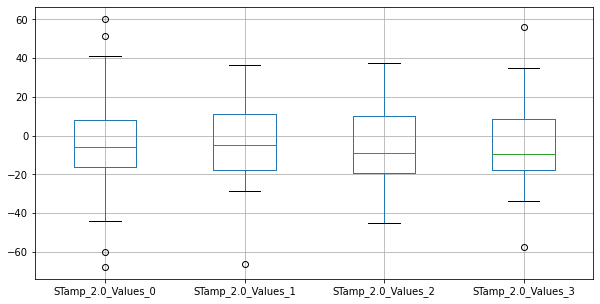

In [185]:
fig = plt.figure(figsize = (10,5))
df7_t3.boxplot()

<AxesSubplot:>

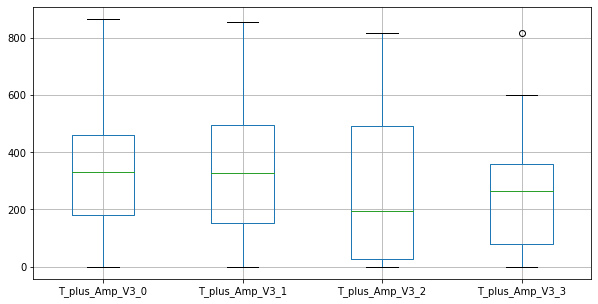

In [186]:
fig = plt.figure(figsize = (10,5))
df8_t3.boxplot()

<AxesSubplot:>

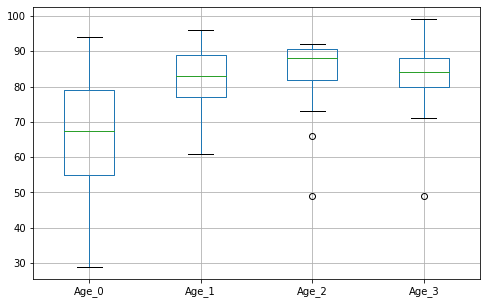

In [187]:
fig = plt.figure(figsize = (8,5))
df9_t3.boxplot()

In [188]:
#create subsets of zero values
sub3_0_1 = sub3[sub3['Label'] == 0].head(29)
sub3_0_2 = sub3[sub3['Label'] == 0].iloc[29:57,:]
sub3_0_3 = sub3[sub3['Label'] == 0].tail(29)

#create final subsets
sub3_1_t = sub3[sub3['Label'] != 0]
sub31 = pd.concat([sub3_0_1, sub3_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub32 = pd.concat([sub3_0_2, sub3_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub33 = pd.concat([sub3_0_3, sub3_1_t], axis = 0).reset_index().drop("index", axis = 1)

In [189]:
#Separating values for sub31
X_sub31 = sub31.iloc[:,:-1]
Y_sub31 = sub31.iloc[:,-1]

#Separating values for sub32
X_sub32 = sub32.iloc[:,:-1]
Y_sub32 = sub32.iloc[:,-1]

#Separating values for sub33
X_sub33 = sub33.iloc[:,:-1]
Y_sub33 = sub33.iloc[:,-1]

## *Random Forest*

In [190]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# define model
model = RandomForestClassifier()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

# define grid
grid = dict()
grid['criterion'] = ["entropy","gini"]
grid['max_depth'] = [i for i in range(1,25)]

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, Y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [191]:
RF_model31 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [192]:
RF_model32 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [193]:
RF_model33 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [194]:
#Training sub31 on the model
RF_model31.fit(X_sub31,Y_sub31)

#Training sub32 on the model
RF_model32.fit(X_sub32,Y_sub32)

#Training sub33 on the model
RF_model33.fit(X_sub33,Y_sub33)

RandomForestClassifier(max_depth=10, random_state=0)

In [195]:
#predict sub31 the results
y_rf31 = RF_model31.predict_proba(X_valid_f)

#predict sub32 the results
y_rf32 = RF_model32.predict_proba(X_valid_f)

#predict sub33 the results
y_rf33 = RF_model33.predict_proba(X_valid_f)

In [196]:
#Finalization
RF_data = {"probs_mean_sub31": y_rf31.mean(axis = 0) , 
      "probs_mean_sub32": y_rf32.mean(axis = 0),
      "probs_mean_sub33": y_rf33.mean(axis = 0)}

RF3 = pd.DataFrame(RF_data, index = ["class0", "class1", "class2", "class3"])
RF3

,probs_mean_sub31,probs_mean_sub32,probs_mean_sub33
class0,0.341258,0.348764,0.372025
class1,0.242047,0.249339,0.241377
class2,0.198941,0.181722,0.179545
class3,0.217754,0.220174,0.207053


In [197]:
#predict sub11 the results
yr_rf31 = RF_model31.predict(X_valid_f)

#predict sub12 the results
yr_rf32 = RF_model32.predict(X_valid_f)

#predict sub13 the results
yr_rf33 = RF_model33.predict(X_valid_f)

In [297]:
#Accuracy Score
acc_score31 = accuracy_score(y_valid_f,yr_rf31)
acc_score32 = accuracy_score(y_valid_f,yr_rf32)
acc_score33 = accuracy_score(y_valid_f,yr_rf33)

#Precicion Score (Sensitivity)
pr_score31 = precision_score(y_valid_f,yr_rf31, average = "macro")
pr_score32 = precision_score(y_valid_f,yr_rf32, average = "macro")
pr_score33 = precision_score(y_valid_f,yr_rf33, average = "macro")

#Recall Score (Speceficity)
re_score31 = recall_score(y_valid_f,yr_rf31, average = "macro")
re_score32 = recall_score(y_valid_f,yr_rf32, average = "macro")
re_score33 = recall_score(y_valid_f,yr_rf33, average = "macro")

#F1-Score
f1_score31 = recall_score(y_valid_f,yr_rf31, average = "macro")
f1_score32 = recall_score(y_valid_f,yr_rf32, average = "macro")
f1_score33 = recall_score(y_valid_f,yr_rf33, average = "macro")

#Finalization
RF_data3 = {"acc_score": [acc_score31,acc_score32,acc_score33] , 
      "pr_score": [pr_score31,pr_score32,pr_score33],
      "recall_score": [re_score31,re_score32,re_score33], "f1-score" : [f1_score31,f1_score32,f1_score33]}

RF3 = pd.DataFrame(RF_data3, index = ["subset31", "subset32", "subset33"])
RF3

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset31,0.531690,0.298116,0.221244,0.221244
subset32,0.492958,0.292697,0.214995,0.214995
subset33,0.563380,0.301413,0.230503,0.230503


## *Logistic Regression*

In [199]:
from sklearn.linear_model import LogisticRegression
LR_model31 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [200]:
LR_model32 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [201]:
LR_model33 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [202]:
#Training sub31 on the model
LR_model31.fit(X_sub31,Y_sub31)

#Training sub32 on the model
LR_model32.fit(X_sub32,Y_sub32)

#Training sub33 on the model
LR_model33.fit(X_sub33,Y_sub33)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.2, penalty='elasticnet', solver='saga')

In [203]:
#predict sub31 the results
y_lr31 = LR_model31.predict_proba(X_valid_f)

#predict sub32 the results
y_lr32 = LR_model32.predict_proba(X_valid_f)

#predict sub33 the results
y_lr33 = LR_model33.predict_proba(X_valid_f)

In [204]:
#Finalization
LR_data = {"probs_mean_sub31": y_lr31.mean(axis = 0) , 
      "probs_mean_sub32": y_lr32.mean(axis = 0),
      "probs_mean_sub33": y_lr33.mean(axis = 0)}

LR3 = pd.DataFrame(LR_data, index = ["class0", "class1", "class2", "class3"])
LR3

,probs_mean_sub31,probs_mean_sub32,probs_mean_sub33
class0,0.278182,0.279285,0.276878
class1,0.241357,0.247186,0.250072
class2,0.238615,0.234061,0.231235
class3,0.241846,0.239467,0.241815


In [205]:
#predict sub11 the results
yr_lr31 = RF_model31.predict(X_valid_f)

#predict sub12 the results
yr_lr32 = RF_model32.predict(X_valid_f)

#predict sub13 the results
yr_lr33 = RF_model33.predict(X_valid_f)

In [296]:
#Accuracy Score
acc_score31 = accuracy_score(y_valid_f,yr_lr31)
acc_score32 = accuracy_score(y_valid_f,yr_lr32)
acc_score33 = accuracy_score(y_valid_f,yr_lr33)

#Precicion Score (Sensitivity)
pr_score31 = precision_score(y_valid_f,yr_lr31, average = "macro")
pr_score32 = precision_score(y_valid_f,yr_lr32, average = "macro")
pr_score33 = precision_score(y_valid_f,yr_lr33, average = "macro")

#Recall Score (Speceficity)
re_score31 = recall_score(y_valid_f,yr_lr31, average = "macro")
re_score32 = recall_score(y_valid_f,yr_lr32, average = "macro")
re_score33 = recall_score(y_valid_f,yr_lr33, average = "macro")

#F1-Score
f1_score31 = recall_score(y_valid_f,yr_lr31, average = "macro")
f1_score32 = recall_score(y_valid_f,yr_lr32, average = "macro")
f1_score33 = recall_score(y_valid_f,yr_lr33, average = "macro")

#Finalization
LR_data3 = {"acc_score": [acc_score31,acc_score32,acc_score33] , 
      "pr_score": [pr_score31,pr_score32,pr_score33],
      "recall_score": [re_score31,re_score32,re_score33], "f1-score" : [f1_score31,f1_score32,f1_score33]}

LR3 = pd.DataFrame(LR_data3, index = ["subset31", "subset32", "subset33"])
LR3

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset31,0.531690,0.298116,0.221244,0.221244
subset32,0.492958,0.292697,0.214995,0.214995
subset33,0.563380,0.301413,0.230503,0.230503


# *Decision Tree*

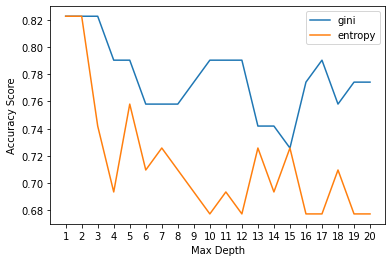

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depth = []
acc_gini = []
acc_entropy = []

for i in range(1,21):
  dtree = DecisionTreeClassifier(criterion = "gini", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_gini.append(accuracy_score(Y_test,pred))

  dtree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_entropy.append(accuracy_score(Y_test,pred))

  max_depth.append(i)

df = pd.DataFrame({"acc_gini" : pd.Series(acc_gini),
                   "acc_entropy" : pd.Series(acc_entropy), 
                   "max_depth" : pd.Series(max_depth)})

plt.plot("max_depth", "acc_gini", data = df, label = "gini")
plt.plot("max_depth", "acc_entropy", data = df, label = "entropy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.xticks([j for j in range(1,21)])
plt.legend()
plt.show()

In [207]:
DT_model31 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [208]:
DT_model32 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [209]:
DT_model33 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [211]:
#Training sub31 on the model
DT_model31.fit(X_sub31,Y_sub31)

#Training sub32 on the model
DT_model32.fit(X_sub32,Y_sub32)

#Training sub33 on the model
DT_model33.fit(X_sub33,Y_sub33)

DecisionTreeClassifier(max_depth=3)

In [ ]:
#predict sub31 the results
y_dt31 = DT_model31.predict_proba(X_valid_f)

#predict sub32 the results
y_dt32 = DT_model32.predict_proba(X_valid_f)

#predict sub33 the results
y_dt33 = DT_model33.predict_proba(X_valid_f)

In [ ]:
#Finalization
DT_data = {"probs_mean_sub31": y_dt31.mean(axis = 0) , 
      "probs_mean_sub32": y_dt32.mean(axis = 0),
      "probs_mean_sub33": y_dt33.mean(axis = 0)}

DT3 = pd.DataFrame(DT_data, index = ["class0", "class1", "class2", "class3"])
DT3

,probs_mean_sub31,probs_mean_sub32,probs_mean_sub33
class0,0.279800,0.303710,0.328527
class1,0.210648,0.225023,0.191143
class2,0.288346,0.238205,0.259161
class3,0.221206,0.233063,0.221169


In [212]:
#predict sub11 the results
yr_dt31 = DT_model31.predict(X_valid_f)

#predict sub12 the results
yr_dt32 = DT_model32.predict(X_valid_f)

#predict sub13 the results
yr_dt33 = DT_model33.predict(X_valid_f)

In [312]:
#Accuracy Score
acc_score31 = accuracy_score(y_valid_f,yr_dt31)
acc_score32 = accuracy_score(y_valid_f,yr_dt32)
acc_score33 = accuracy_score(y_valid_f,yr_dt33)

#Precicion Score (Sensitivity)
pr_score31 = precision_score(y_valid_f,yr_dt31, average = "macro")
pr_score32 = precision_score(y_valid_f,yr_dt32, average = "macro")
pr_score33 = precision_score(y_valid_f,yr_dt33, average = "macro")

#Recall Score (Speceficity)
re_score31 = recall_score(y_valid_f,yr_dt31, average = "macro")
re_score32 = recall_score(y_valid_f,yr_dt32, average = "macro")
re_score33 = recall_score(y_valid_f,yr_dt33, average = "macro")

#F1-Score
f1_score31 = recall_score(y_valid_f,yr_dt31, average = "macro")
f1_score32 = recall_score(y_valid_f,yr_dt32, average = "macro")
f1_score33 = recall_score(y_valid_f,yr_dt33, average = "macro")

#Finalization
DT_data3 = {"acc_score": [acc_score31,acc_score32,acc_score33] , 
      "pr_score": [pr_score31,pr_score32,pr_score33],
      "recall_score": [re_score31,re_score32,re_score33], "f1-score" : [f1_score31,f1_score32,f1_score33]}

DT3 = pd.DataFrame(DT_data3, index = ["subset31", "subset32", "subset33"])
DT3

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset31,0.426056,0.312424,0.190379,0.190379
subset32,0.373239,0.399510,0.327880,0.327880
subset33,0.528169,0.317214,0.225284,0.225284


# ***Subset4***

In [214]:
sub4_1 = sub4[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age','Label']]
sub4_1

,P_Area_V1,P_Area_V4,P_Morph_V6,QRS_Pseudo_Vector_7/8_Spatial_Velocity,R_Dur_II,R_Notch_V2,STamp_2.0_Values,T_plus_Amp_V3,Sex,Age,Label
811,-137.0,-4.0,1.0,30.0,90.0,0.0,13.75,390.0,1.0,62.0,0.0
813,-103.0,50.0,1.0,12.0,52.0,0.0,-30.00,54.0,0.0,69.0,0.0
155,1.0,109.0,1.0,22.0,34.0,0.0,16.25,140.0,1.0,84.0,0.0
359,125.0,-83.0,1.0,39.0,44.0,0.0,-1.25,349.0,1.0,86.0,0.0
303,-44.0,-211.0,1.0,14.0,82.0,0.0,-18.75,520.0,1.0,78.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
827,-74.0,-37.0,1.0,32.0,36.0,0.0,8.75,401.0,0.0,88.0,1.0
828,54.0,-163.0,1.0,21.0,30.0,0.0,26.25,384.0,0.0,88.0,1.0
829,5.8,-137.8,1.0,28.0,35.0,0.0,-8.75,318.0,0.0,88.0,1.0
832,0.0,-1.0,1.0,26.0,80.0,0.0,-17.50,303.0,1.0,86.0,1.0


In [215]:
sub4_1_0 = sub4_1[sub4_1["Label"] == 0]
sub4_1_1 = sub4_1[sub4_1["Label"] == 1]

In [216]:
data_morto_14 = sub4_1_1.head(29).replace({"Label" : 1}, 1)
data_morto_24= sub4_1_1.iloc[29:57,:].replace({"Label" : 1}, 2)
data_morto_34 = sub4_1_1.tail(29).replace({"Label" : 1}, 3)

In [217]:
sub4 = pd.concat([sub4_1_0,data_morto_14,data_morto_24,data_morto_34], axis = 0).reset_index().drop("index", axis = 1)

In [218]:
#Feature 1
df1_04 = sub4[sub4["Label"] == 0].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_0"})
df1_14 = sub4[sub4["Label"] == 1].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_1"})
df1_24 = sub4[sub4["Label"] == 2].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_2"})
df1_34 = sub4[sub4["Label"] == 3].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_3"})
df1_t4 = pd.concat([df1_04,df1_14,df1_24,df1_34], axis = 1)

#Feature 2
df2_04 = sub4[sub4["Label"] == 0].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_0"})
df2_14 = sub4[sub4["Label"] == 1].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_1"})
df2_24 = sub4[sub4["Label"] == 2].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_2"})
df2_34 = sub4[sub4["Label"] == 3].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_3"})
df2_t4 = pd.concat([df2_04,df2_14,df2_24,df2_34], axis = 1)

#Feature 3
df3_04 = sub4[sub4["Label"] == 0].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_0"})
df3_14 = sub4[sub4["Label"] == 1].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_1"})
df3_24 = sub4[sub4["Label"] == 2].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_2"})
df3_34 = sub4[sub4["Label"] == 3].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_3"})
df3_t4 = pd.concat([df3_04,df3_14,df3_24,df3_34], axis = 1)

#Feature 4
df4_04 = sub4[sub4["Label"] == 0].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_0"})
df4_14 = sub4[sub4["Label"] == 1].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_1"})
df4_24 = sub4[sub4["Label"] == 2].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_2"})
df4_34 = sub4[sub4["Label"] == 3].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_3"})
df4_t4 = pd.concat([df4_04,df4_14,df4_24,df4_34], axis = 1)
#Feature 5
df5_04 = sub4[sub4["Label"] == 0].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_0"})
df5_14 = sub4[sub4["Label"] == 1].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_1"})
df5_24 = sub4[sub4["Label"] == 2].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_2"})
df5_34 = sub4[sub4["Label"] == 3].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_3"})
df5_t4 = pd.concat([df5_04,df5_14,df5_24,df5_34], axis = 1)

#Feature 6
df6_04 = sub4[sub4["Label"] == 0].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_0"})
df6_14 = sub4[sub4["Label"] == 1].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_1"})
df6_24 = sub4[sub4["Label"] == 2].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_2"})
df6_34 = sub4[sub4["Label"] == 3].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_3"})
df6_t4 = pd.concat([df6_04,df6_14,df6_24,df6_34], axis = 1)

#Feature 7
df7_04 = sub4[sub4["Label"] == 0].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_0"})
df7_14 = sub4[sub4["Label"] == 1].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_1"})
df7_24 = sub4[sub4["Label"] == 2].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_2"})
df7_34 = sub4[sub4["Label"] == 3].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_3"})
df7_t4 = pd.concat([df7_04,df7_14,df7_24,df7_34], axis = 1)

#Feature 8
df8_04 = sub4[sub4["Label"] == 0].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_0"})
df8_14 = sub4[sub4["Label"] == 1].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_1"})
df8_24 = sub4[sub4["Label"] == 2].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_2"})
df8_34 = sub4[sub4["Label"] == 3].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_3"})
df8_t4 = pd.concat([df8_04,df8_14,df8_24,df8_34], axis = 1)

#Feature 9
df9_04 = sub4[sub4["Label"] == 0].iloc[:,[9]].rename(columns = {"Age" : "Age_0"})
df9_14 = sub4[sub4["Label"] == 1].iloc[:,[9]].rename(columns = {"Age" : "Age_1"})
df9_24 = sub4[sub4["Label"] == 2].iloc[:,[9]].rename(columns = {"Age" : "Age_2"})
df9_34 = sub4[sub4["Label"] == 3].iloc[:,[9]].rename(columns = {"Age" : "Age_3"})
df9_t4 = pd.concat([df9_04,df9_14,df9_24,df9_34], axis = 1)

<AxesSubplot:>

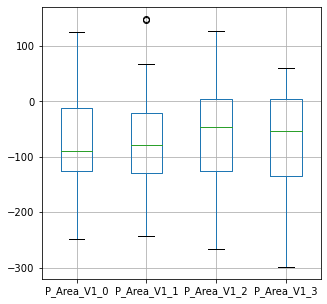

In [219]:
fig = plt.figure(figsize = (5,5))
df1_t4.boxplot()

<AxesSubplot:>

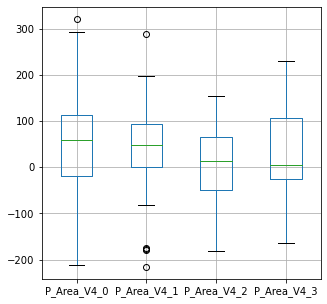

In [220]:
fig = plt.figure(figsize = (5,5))
df2_t4.boxplot()

<AxesSubplot:>

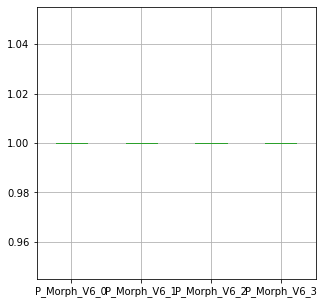

In [221]:
fig = plt.figure(figsize = (5,5))
df3_t4.boxplot()

<AxesSubplot:>

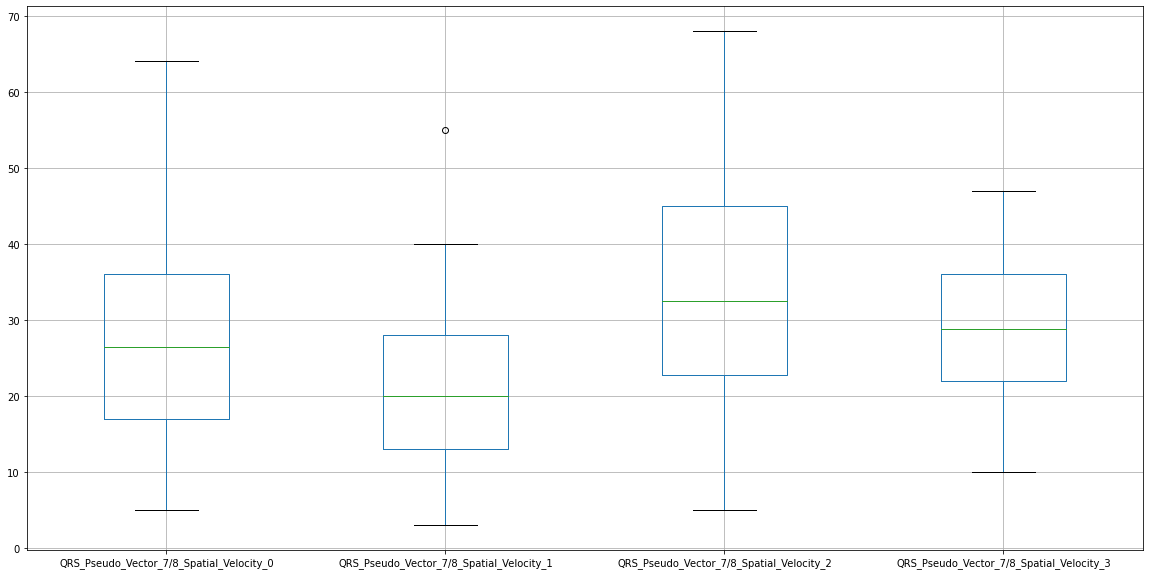

In [222]:
fig = plt.figure(figsize = (20,10))
df4_t4.boxplot()

<AxesSubplot:>

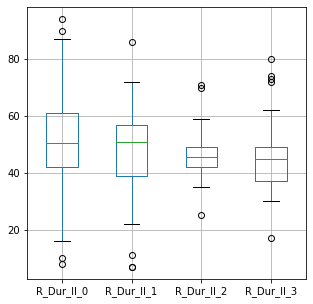

In [223]:
fig = plt.figure(figsize = (5,5))
df5_t4.boxplot()

<AxesSubplot:>

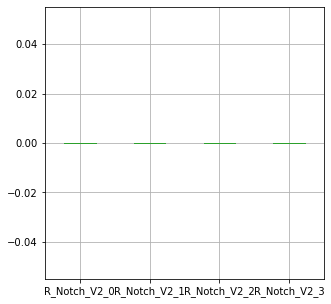

In [224]:
fig = plt.figure(figsize = (5,5))
df6_t4.boxplot()

<AxesSubplot:>

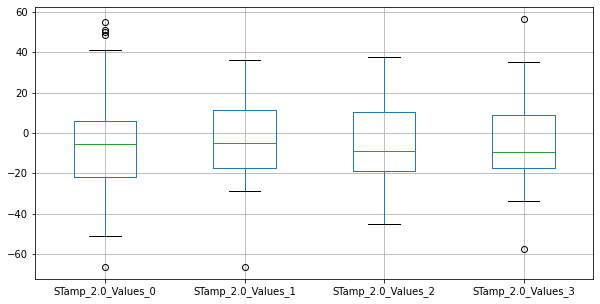

In [225]:
fig = plt.figure(figsize = (10,5))
df7_t4.boxplot()

<AxesSubplot:>

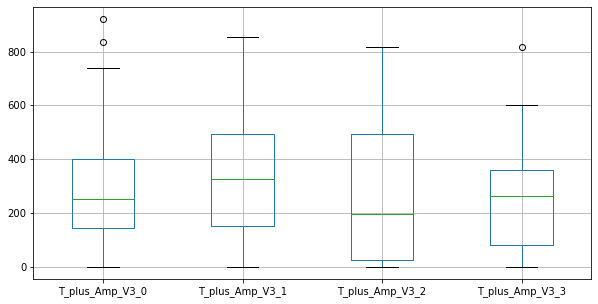

In [226]:
fig = plt.figure(figsize = (10,5))
df8_t4.boxplot()

<AxesSubplot:>

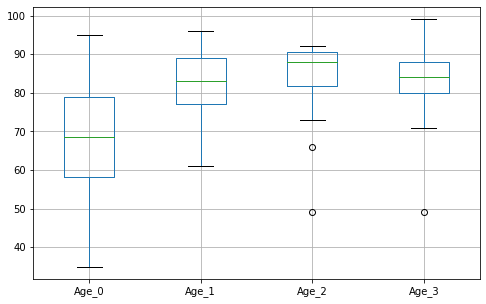

In [227]:
fig = plt.figure(figsize = (8,5))
df9_t4.boxplot()

In [228]:
#create subsets of zero values
sub4_0_1 = sub4[sub4['Label'] == 0].head(29)
sub4_0_2 = sub4[sub4['Label'] == 0].iloc[29:57,:]
sub4_0_3 = sub4[sub4['Label'] == 0].tail(29)

#create final subsets
sub4_1_t = sub4[sub4['Label'] != 0]
sub41 = pd.concat([sub4_0_1, sub4_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub42 = pd.concat([sub4_0_2, sub4_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub43 = pd.concat([sub4_0_3, sub4_1_t], axis = 0).reset_index().drop("index", axis = 1)

In [229]:
#Separating values for sub41
X_sub41 = sub41.iloc[:,:-1]
Y_sub41 = sub41.iloc[:,-1]

#Separating values for sub42
X_sub42 = sub42.iloc[:,:-1]
Y_sub42 = sub42.iloc[:,-1]

#Separating values for sub43
X_sub43 = sub43.iloc[:,:-1]
Y_sub43 = sub43.iloc[:,-1]

## *Random Forest*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# define model
model = RandomForestClassifier()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

# define grid
grid = dict()
grid['criterion'] = ["entropy","gini"]
grid['max_depth'] = [i for i in range(1,25)]

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, Y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [230]:
RF_model41 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [231]:
RF_model42 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [232]:
RF_model43 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [233]:
#Training sub41 on the model
RF_model41.fit(X_sub41,Y_sub41)

#Training sub42 on the model
RF_model42.fit(X_sub42,Y_sub42)

#Training sub43 on the model
RF_model43.fit(X_sub43,Y_sub43)

RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
#predict sub41 the results
y_rf41 = RF_model41.predict_proba(X_valid_f)

#predict sub42 the results
y_rf42 = RF_model42.predict_proba(X_valid_f)

#predict sub43 the results
y_rf43 = RF_model43.predict_proba(X_valid_f)

In [ ]:
#Finalization
RF_data = {"probs_mean_sub41": y_rf41.mean(axis = 0) , 
      "probs_mean_sub42": y_rf42.mean(axis = 0),
      "probs_mean_sub43": y_rf43.mean(axis = 0)}

RF4 = pd.DataFrame(RF_data, index = ["class0", "class1", "class2", "class3"])
RF4

,probs_mean_sub41,probs_mean_sub42,probs_mean_sub43
class0,0.338051,0.321594,0.309323
class1,0.207431,0.229023,0.209986
class2,0.221129,0.210515,0.232166
class3,0.233389,0.238868,0.248525


In [234]:
#predict sub11 the results
yr_rf41 = RF_model41.predict(X_valid_f)

#predict sub12 the results
yr_rf42 = RF_model42.predict(X_valid_f)

#predict sub13 the results
yr_rf43 = RF_model43.predict(X_valid_f)

In [311]:
#Accuracy Score
acc_score41 = accuracy_score(y_valid_f,yr_rf41)
acc_score42 = accuracy_score(y_valid_f,yr_rf42)
acc_score43 = accuracy_score(y_valid_f,yr_rf43)

#Precicion Score (Sensitivity)
pr_score41 = precision_score(y_valid_f,yr_rf41, average = "macro")
pr_score42 = precision_score(y_valid_f,yr_rf42, average = "macro")
pr_score43 = precision_score(y_valid_f,yr_rf43, average = "macro")

#Recall Score (Speceficity)
re_score41 = recall_score(y_valid_f,yr_rf41, average = "macro")
re_score42 = recall_score(y_valid_f,yr_rf42, average = "macro")
re_score43 = recall_score(y_valid_f,yr_rf43, average = "macro")

#F1-Score
f1_score41 = recall_score(y_valid_f,yr_rf41, average = "macro")
f1_score42 = recall_score(y_valid_f,yr_rf42, average = "macro")
f1_score43 = recall_score(y_valid_f,yr_rf43, average = "macro")

#Finalization
RF_data4 = {"acc_score": [acc_score41,acc_score42,acc_score43] , 
      "pr_score": [pr_score41,pr_score42,pr_score43],
      "recall_score": [re_score41,re_score42,re_score43], "f1-score" : [f1_score41,f1_score42,f1_score43]}

RF4 = pd.DataFrame(RF_data4, index = ["subset41", "subset42", "subset43"])
RF4

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset41,0.496479,0.294444,0.205887,0.205887
subset42,0.492958,0.284719,0.204858,0.204858
subset43,0.496479,0.269266,0.180543,0.180543


## *Logistic Regression*

In [236]:
from sklearn.linear_model import LogisticRegression
LR_model41 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [237]:
LR_model42 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [238]:
LR_model43 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [239]:
#Training sub41 on the model
LR_model41.fit(X_sub41,Y_sub41)

#Training sub42 on the model
LR_model42.fit(X_sub42,Y_sub42)

#Training sub43 on the model
LR_model43.fit(X_sub43,Y_sub43)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.2, penalty='elasticnet', solver='saga')

In [ ]:
#predict sub41 the results
y_lr41 = LR_model41.predict_proba(X_valid_f)

#predict sub42 the results
y_lr42 = LR_model42.predict_proba(X_valid_f)

#predict sub43 the results
y_lr43 = LR_model43.predict_proba(X_valid_f)

In [ ]:
#Finalization
LR_data = {"probs_mean_sub41": y_lr41.mean(axis = 0) , 
      "probs_mean_sub42": y_lr42.mean(axis = 0),
      "probs_mean_sub43": y_lr43.mean(axis = 0)}

LR4 = pd.DataFrame(LR_data, index = ["class0", "class1", "class2", "class3"])
LR4

,probs_mean_sub41,probs_mean_sub42,probs_mean_sub43
class0,0.278068,0.271704,0.260947
class1,0.220612,0.232717,0.239965
class2,0.248620,0.242718,0.244040
class3,0.252701,0.252861,0.255048


In [240]:
#predict sub11 the results
yr_lr41 = LR_model41.predict(X_valid_f)

#predict sub12 the results
yr_lr42 = LR_model42.predict(X_valid_f)

#predict sub13 the results
yr_lr43 = LR_model43.predict(X_valid_f)

In [310]:
#Accuracy Score
acc_score41 = accuracy_score(y_valid_f,yr_lr41)
acc_score42 = accuracy_score(y_valid_f,yr_lr42)
acc_score43 = accuracy_score(y_valid_f,yr_lr43)

#Precicion Score (Sensitivity)
pr_score41 = precision_score(y_valid_f,yr_lr41, average = "macro")
pr_score42 = precision_score(y_valid_f,yr_lr42, average = "macro")
pr_score43 = precision_score(y_valid_f,yr_lr43, average = "macro")

#Recall Score (Speceficity)
re_score41 = recall_score(y_valid_f,yr_lr41, average = "macro")
re_score42 = recall_score(y_valid_f,yr_lr42, average = "macro")
re_score43 = recall_score(y_valid_f,yr_lr43, average = "macro")

#F1-Score
f1_score41 = recall_score(y_valid_f,yr_lr41, average = "macro")
f1_score42 = recall_score(y_valid_f,yr_lr42, average = "macro")
f1_score43 = recall_score(y_valid_f,yr_lr43, average = "macro")

#Finalization
LR_data4 = {"acc_score": [acc_score41,acc_score42,acc_score43] , 
      "pr_score": [pr_score41,pr_score42,pr_score43],
      "recall_score": [re_score41,re_score42,re_score43], "f1-score" : [f1_score41,f1_score42,f1_score43]}

LR4 = pd.DataFrame(LR_data4, index = ["subset41", "subset42", "subset43"])
LR4

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset41,0.433099,0.285813,0.202575,0.202575
subset42,0.461268,0.301615,0.215874,0.215874
subset43,0.411972,0.286787,0.196402,0.196402


# *Decision Tree*

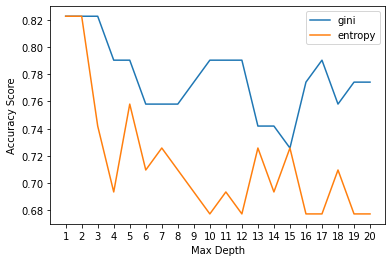

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depth = []
acc_gini = []
acc_entropy = []

for i in range(1,21):
  dtree = DecisionTreeClassifier(criterion = "gini", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_gini.append(accuracy_score(Y_test,pred))

  dtree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_entropy.append(accuracy_score(Y_test,pred))

  max_depth.append(i)

df = pd.DataFrame({"acc_gini" : pd.Series(acc_gini),
                   "acc_entropy" : pd.Series(acc_entropy), 
                   "max_depth" : pd.Series(max_depth)})

plt.plot("max_depth", "acc_gini", data = df, label = "gini")
plt.plot("max_depth", "acc_entropy", data = df, label = "entropy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.xticks([j for j in range(1,21)])
plt.legend()
plt.show()

In [242]:
DT_model41 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [243]:
DT_model42 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [244]:
DT_model43 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [245]:
#Training sub41 on the model
DT_model41.fit(X_sub41,Y_sub41)

#Training sub42 on the model
DT_model42.fit(X_sub42,Y_sub42)

#Training sub43 on the model
DT_model43.fit(X_sub43,Y_sub43)

DecisionTreeClassifier(max_depth=3)

In [ ]:
#predict sub41 the results
y_dt41 = DT_model41.predict_proba(X_valid_f)

#predict sub42 the results
y_dt42 = DT_model42.predict_proba(X_valid_f)

#predict sub43 the results
y_dt43 = DT_model43.predict_proba(X_valid_f)

In [ ]:
#Finalization
DT_data = {"probs_mean_sub41": y_dt41.mean(axis = 0) , 
      "probs_mean_sub42": y_dt42.mean(axis = 0),
      "probs_mean_sub43": y_dt43.mean(axis = 0)}

DT4 = pd.DataFrame(DT_data, index = ["class0", "class1", "class2", "class3"])
DT4

,probs_mean_sub41,probs_mean_sub42,probs_mean_sub43
class0,0.365054,0.370386,0.293026
class1,0.179603,0.175117,0.168284
class2,0.219186,0.233424,0.315012
class3,0.236157,0.221073,0.223677


In [246]:
#predict sub11 the results
yr_dt41 = DT_model41.predict(X_valid_f)

#predict sub12 the results
yr_dt42 = DT_model42.predict(X_valid_f)

#predict sub13 the results
yr_dt43 = DT_model43.predict(X_valid_f)

In [309]:
#Accuracy Score
acc_score41 = accuracy_score(y_valid_f,yr_dt41)
acc_score42 = accuracy_score(y_valid_f,yr_dt42)
acc_score43 = accuracy_score(y_valid_f,yr_dt43)

#Precicion Score (Sensitivity)
pr_score41 = precision_score(y_valid_f,yr_dt41, average = "macro")
pr_score42 = precision_score(y_valid_f,yr_dt42, average = "macro")
pr_score43 = precision_score(y_valid_f,yr_dt43, average = "macro")

#Recall Score (Speceficity)
re_score41 = recall_score(y_valid_f,yr_dt41, average = "macro")
re_score42 = recall_score(y_valid_f,yr_dt42, average = "macro")
re_score43 = recall_score(y_valid_f,yr_dt43, average = "macro")

#F1-Score
f1_score41 = recall_score(y_valid_f,yr_dt41, average = "macro")
f1_score42 = recall_score(y_valid_f,yr_dt42, average = "macro")
f1_score43 = recall_score(y_valid_f,yr_dt43, average = "macro")

#Finalization
DT_data4 = {"acc_score": [acc_score41,acc_score42,acc_score43] , 
      "pr_score": [pr_score41,pr_score42,pr_score43],
      "recall_score": [re_score41,re_score42,re_score43], "f1-score" : [f1_score41,f1_score42,f1_score43]}

DT4 = pd.DataFrame(DT_data4, index = ["subset41", "subset42", "subset43"])
DT4

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset41,0.485915,0.312239,0.223075,0.223075
subset42,0.411972,0.293314,0.206539,0.206539
subset43,0.517606,0.311508,0.277953,0.277953


# ***Subset5***

In [248]:
sub5_1 = sub5[['P_Area_V1','P_Area_V4','P_Morph_V6',
                'QRS_Pseudo_Vector_7/8_Spatial_Velocity', 'R_Dur_II',
               'R_Notch_V2','STamp_2.0_Values','T_plus_Amp_V3','Sex', 'Age','Label']]
sub5_1

,P_Area_V1,P_Area_V4,P_Morph_V6,QRS_Pseudo_Vector_7/8_Spatial_Velocity,R_Dur_II,R_Notch_V2,STamp_2.0_Values,T_plus_Amp_V3,Sex,Age,Label
312,-115.0,-129.2,1.0,19.0,35.0,0.0,25.00,408.0,0.0,79.0,0.0
388,-22.0,170.0,1.0,9.0,63.0,0.0,-47.50,288.0,1.0,60.0,0.0
24,-75.0,268.0,1.0,29.0,50.0,0.0,-17.50,161.0,0.0,58.0,0.0
14,-89.0,-47.0,1.0,8.0,56.8,0.0,-17.50,292.0,1.0,70.0,0.0
55,1.0,-7.0,1.0,25.0,76.0,0.0,-15.00,367.0,1.0,76.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
827,-74.0,-37.0,1.0,32.0,36.0,0.0,8.75,401.0,0.0,88.0,1.0
828,54.0,-163.0,1.0,21.0,30.0,0.0,26.25,384.0,0.0,88.0,1.0
829,5.8,-137.8,1.0,28.0,35.0,0.0,-8.75,318.0,0.0,88.0,1.0
832,0.0,-1.0,1.0,26.0,80.0,0.0,-17.50,303.0,1.0,86.0,1.0


In [249]:
sub5_1_0 = sub5_1[sub5_1["Label"] == 0]
sub5_1_1 = sub5_1[sub5_1["Label"] == 1]

In [250]:
data_morto_15 = sub5_1_1.head(29).replace({"Label" : 1}, 1)
data_morto_25 = sub5_1_1.iloc[29:57,:].replace({"Label" : 1}, 2)
data_morto_35 = sub5_1_1.tail(29).replace({"Label" : 1}, 3)

In [251]:
sub5 = pd.concat([sub5_1_0,data_morto_15,data_morto_25,data_morto_35], axis = 0).reset_index().drop("index", axis = 1)

In [252]:
#Feature 1
df1_05 = sub5[sub5["Label"] == 0].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_0"})
df1_15 = sub5[sub5["Label"] == 1].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_1"})
df1_25 = sub5[sub5["Label"] == 2].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_2"})
df1_35 = sub5[sub5["Label"] == 3].iloc[:,[0]].rename(columns = {"P_Area_V1" : "P_Area_V1_3"})
df1_t5 = pd.concat([df1_05,df1_15,df1_25,df1_35], axis = 1)

#Feature 2
df2_05 = sub5[sub5["Label"] == 0].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_0"})
df2_15 = sub5[sub5["Label"] == 1].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_1"})
df2_25 = sub5[sub5["Label"] == 2].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_2"})
df2_35 = sub5[sub5["Label"] == 3].iloc[:,[1]].rename(columns = {"P_Area_V4" : "P_Area_V4_3"})
df2_t5 = pd.concat([df2_05,df2_15,df2_25,df2_35], axis = 1)

#Feature 3
df3_05 = sub5[sub5["Label"] == 0].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_0"})
df3_15 = sub5[sub5["Label"] == 1].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_1"})
df3_25 = sub5[sub5["Label"] == 2].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_2"})
df3_35 = sub5[sub5["Label"] == 3].iloc[:,[2]].rename(columns = {"P_Morph_V6" : "P_Morph_V6_3"})
df3_t5 = pd.concat([df3_05,df3_15,df3_25,df3_35], axis = 1)

#Feature 4
df4_05 = sub5[sub5["Label"] == 0].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_0"})
df4_15 = sub5[sub5["Label"] == 1].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_1"})
df4_25 = sub5[sub5["Label"] == 2].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_2"})
df4_35 = sub5[sub5["Label"] == 3].iloc[:,[3]].rename(columns = {"QRS_Pseudo_Vector_7/8_Spatial_Velocity" : "QRS_Pseudo_Vector_7/8_Spatial_Velocity_3"})
df4_t5 = pd.concat([df4_05,df4_15,df4_25,df4_35], axis = 1)
#Feature 5
df5_05 = sub5[sub5["Label"] == 0].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_0"})
df5_15 = sub5[sub5["Label"] == 1].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_1"})
df5_25 = sub5[sub5["Label"] == 2].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_2"})
df5_35 = sub5[sub5["Label"] == 3].iloc[:,[4]].rename(columns = {"R_Dur_II" : "R_Dur_II_3"})
df5_t5 = pd.concat([df5_05,df5_15,df5_25,df5_35], axis = 1)

#Feature 6
df6_05 = sub5[sub5["Label"] == 0].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_0"})
df6_15 = sub5[sub5["Label"] == 1].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_1"})
df6_25 = sub5[sub5["Label"] == 2].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_2"})
df6_35 = sub5[sub5["Label"] == 3].iloc[:,[5]].rename(columns = {"R_Notch_V2" : "R_Notch_V2_3"})
df6_t5 = pd.concat([df6_05,df6_15,df6_25,df6_35], axis = 1)

#Feature 7
df7_05 = sub5[sub5["Label"] == 0].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_0"})
df7_15 = sub5[sub5["Label"] == 1].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_1"})
df7_25 = sub5[sub5["Label"] == 2].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_2"})
df7_35 = sub5[sub5["Label"] == 3].iloc[:,[6]].rename(columns = {"STamp_2.0_Values" : "STamp_2.0_Values_3"})
df7_t5 = pd.concat([df7_05,df7_15,df7_25,df7_35], axis = 1)

#Feature 8
df8_05 = sub5[sub5["Label"] == 0].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_0"})
df8_15 = sub5[sub5["Label"] == 1].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_1"})
df8_25 = sub5[sub5["Label"] == 2].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_2"})
df8_35 = sub5[sub5["Label"] == 3].iloc[:,[7]].rename(columns = {"T_plus_Amp_V3" : "T_plus_Amp_V3_3"})
df8_t5 = pd.concat([df8_05,df8_15,df8_25,df8_35], axis = 1)

#Feature 9
df9_05 = sub5[sub5["Label"] == 0].iloc[:,[9]].rename(columns = {"Age" : "Age_0"})
df9_15 = sub5[sub5["Label"] == 1].iloc[:,[9]].rename(columns = {"Age" : "Age_1"})
df9_25 = sub5[sub5["Label"] == 2].iloc[:,[9]].rename(columns = {"Age" : "Age_2"})
df9_35 = sub5[sub5["Label"] == 3].iloc[:,[9]].rename(columns = {"Age" : "Age_3"})
df9_t5 = pd.concat([df9_05,df9_15,df9_25,df9_35], axis = 1)

<AxesSubplot:>

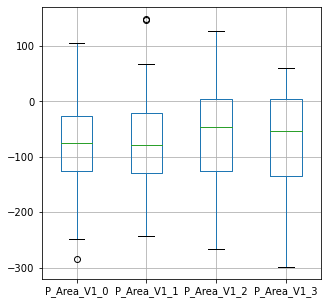

In [253]:
fig = plt.figure(figsize = (5,5))
df1_t5.boxplot()

<AxesSubplot:>

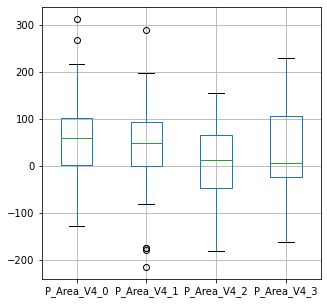

In [254]:
fig = plt.figure(figsize = (5,5))
df2_t5.boxplot()

<AxesSubplot:>

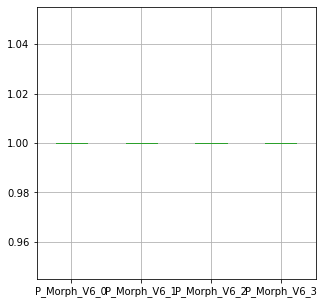

In [255]:
fig = plt.figure(figsize = (5,5))
df3_t5.boxplot()

<AxesSubplot:>

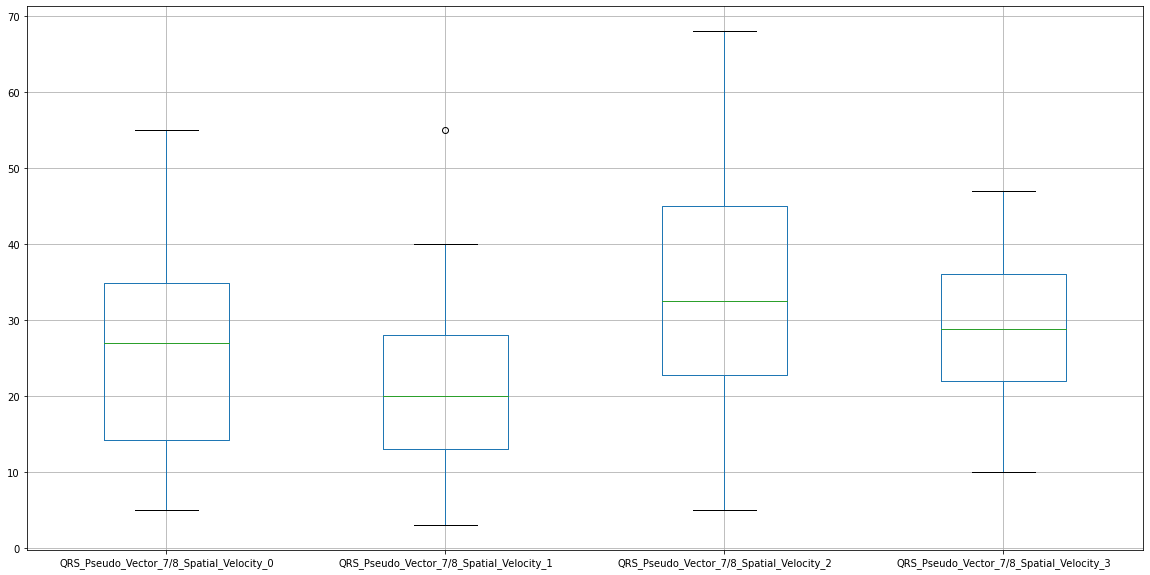

In [256]:
fig = plt.figure(figsize = (20,10))
df4_t5.boxplot()

<AxesSubplot:>

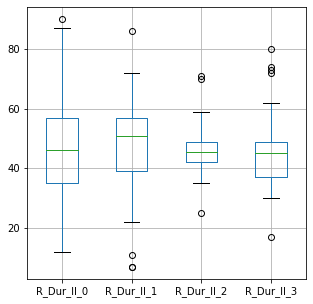

In [257]:
fig = plt.figure(figsize = (5,5))
df5_t5.boxplot()

<AxesSubplot:>

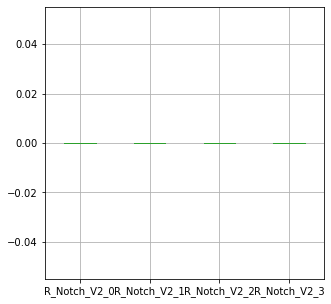

In [258]:
fig = plt.figure(figsize = (5,5))
df6_t5.boxplot()

<AxesSubplot:>

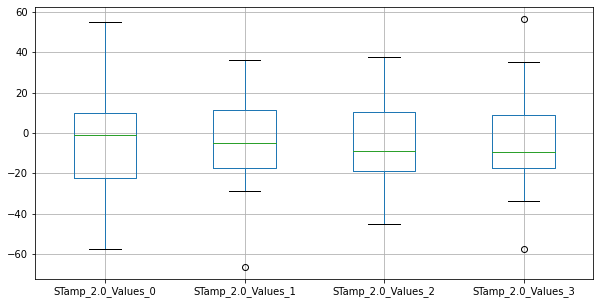

In [259]:
fig = plt.figure(figsize = (10,5))
df7_t5.boxplot()

<AxesSubplot:>

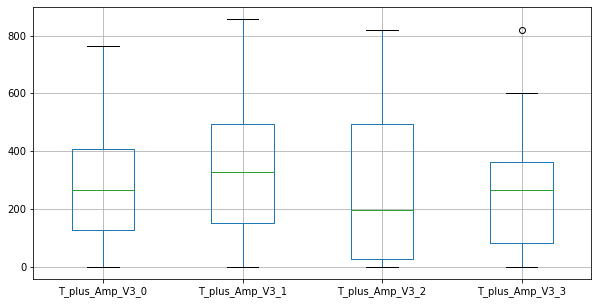

In [260]:
fig = plt.figure(figsize = (10,5))
df8_t5.boxplot()

<AxesSubplot:>

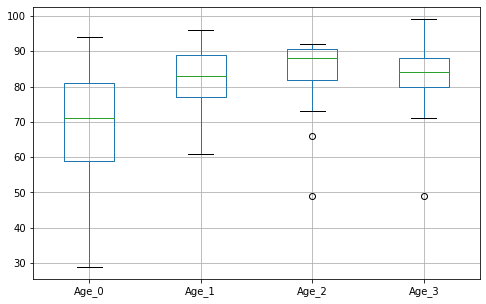

In [261]:
fig = plt.figure(figsize = (8,5))
df9_t5.boxplot()

In [262]:
#create subsets of zero values
sub5_0_1 = sub5[sub5['Label'] == 0].head(29)
sub5_0_2 = sub5[sub5['Label'] == 0].iloc[29:57,:]
sub5_0_3 = sub5[sub5['Label'] == 0].tail(29)

#create final subsets
sub5_1_t = sub5[sub5['Label'] != 0]
sub51 = pd.concat([sub5_0_1, sub5_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub52 = pd.concat([sub5_0_2, sub5_1_t], axis = 0).reset_index().drop("index", axis = 1)
sub53 = pd.concat([sub5_0_3, sub5_1_t], axis = 0).reset_index().drop("index", axis = 1)

In [263]:
#Separating values for sub51
X_sub51 = sub51.iloc[:,:-1]
Y_sub51 = sub51.iloc[:,-1]

#Separating values for sub52
X_sub52 = sub52.iloc[:,:-1]
Y_sub52 = sub52.iloc[:,-1]

#Separating values for sub53
X_sub53 = sub53.iloc[:,:-1]
Y_sub53 = sub53.iloc[:,-1]

## *Random Forest*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# define model
model = RandomForestClassifier()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

# define grid
grid = dict()
grid['criterion'] = ["entropy","gini"]
grid['max_depth'] = [i for i in range(1,25)]

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, Y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

In [264]:
RF_model51 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [265]:
RF_model52 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [266]:
RF_model53 = RandomForestClassifier(n_estimators = 100,
                                    criterion = "gini",
                                    max_depth = 10,
                                    random_state = 0)

In [267]:
#Training sub51 on the model
RF_model51.fit(X_sub51,Y_sub51)

#Training sub52 on the model
RF_model52.fit(X_sub52,Y_sub52)

#Training sub53 on the model
RF_model53.fit(X_sub53,Y_sub53)

RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
#predict sub51 the results
y_rf51 = RF_model51.predict_proba(X_valid_f)

#predict sub52 the results
y_rf52 = RF_model52.predict_proba(X_valid_f)

#predict sub53 the results
y_rf53 = RF_model53.predict_proba(X_valid_f)

In [ ]:
#Finalization
RF_data = {"probs_mean_sub51": y_rf51.mean(axis = 0) , 
      "probs_mean_sub52": y_rf52.mean(axis = 0),
      "probs_mean_sub53": y_rf53.mean(axis = 0)}

RF5 = pd.DataFrame(RF_data, index = ["class0", "class1", "class2", "class3"])
RF5

,probs_mean_sub51,probs_mean_sub52,probs_mean_sub53
class0,0.343861,0.312427,0.339236
class1,0.213532,0.219975,0.226369
class2,0.211711,0.230426,0.209628
class3,0.230896,0.237172,0.224768


In [268]:
#predict sub11 the results
yr_rf51 = RF_model51.predict(X_valid_f)

#predict sub12 the results
yr_rf52 = RF_model52.predict(X_valid_f)

#predict sub13 the results
yr_rf53 = RF_model53.predict(X_valid_f)

In [308]:
#Accuracy Score
acc_score51 = accuracy_score(y_valid_f,yr_rf51)
acc_score52 = accuracy_score(y_valid_f,yr_rf52)
acc_score53 = accuracy_score(y_valid_f,yr_rf53)

#Precicion Score (Sensitivity)
pr_score51 = precision_score(y_valid_f,yr_rf51, average = "macro")
pr_score52 = precision_score(y_valid_f,yr_rf52, average = "macro")
pr_score53 = precision_score(y_valid_f,yr_rf53, average = "macro")

#Recall Score (Speceficity)
re_score51 = recall_score(y_valid_f,yr_rf51, average = "macro")
re_score52 = recall_score(y_valid_f,yr_rf52, average = "macro")
re_score53 = recall_score(y_valid_f,yr_rf53, average = "macro")

#F1-Score
f1_score51 = recall_score(y_valid_f,yr_rf51, average = "macro")
f1_score52 = recall_score(y_valid_f,yr_rf52, average = "macro")
f1_score53 = recall_score(y_valid_f,yr_rf53, average = "macro")

#Finalization
RF_data5 = {"acc_score": [acc_score51,acc_score52,acc_score53] , 
      "pr_score": [pr_score51,pr_score52,pr_score53],
      "recall_score": [re_score51,re_score52,re_score53], "f1-score" : [f1_score51,f1_score52,f1_score53]}

RF5 = pd.DataFrame(RF_data5, index = ["subset51", "subset52", "subset53"])
RF5

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-score
subset51,0.559859,0.292624,0.224405,0.224405
subset52,0.566901,0.288767,0.231532,0.231532
subset53,0.566901,0.308636,0.236600,0.236600


## *Logistic Regression*

In [271]:
from sklearn.linear_model import LogisticRegression
LR_model51 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [272]:
LR_model52 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [273]:
LR_model53 = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)

In [274]:
#Training sub51 on the model
LR_model51.fit(X_sub51,Y_sub51)

#Training sub52 on the model
LR_model52.fit(X_sub52,Y_sub52)

#Training sub53 on the model
LR_model53.fit(X_sub53,Y_sub53)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.2, penalty='elasticnet', solver='saga')

In [ ]:
#predict sub51 the results
y_lr51 = LR_model51.predict_proba(X_valid_f)

#predict sub52 the results
y_lr52 = LR_model52.predict_proba(X_valid_f)

#predict sub53 the results
y_lr53 = LR_model53.predict_proba(X_valid_f)

In [ ]:
#Finalization
LR_data = {"probs_mean_sub51": y_lr51.mean(axis = 0) , 
      "probs_mean_sub52": y_lr52.mean(axis = 0),
      "probs_mean_sub53": y_lr53.mean(axis = 0)}

LR5 = pd.DataFrame(LR_data, index = ["class0", "class1", "class2", "class3"])
LR5

,probs_mean_sub51,probs_mean_sub52,probs_mean_sub53
class0,0.293544,0.273344,0.287379
class1,0.227989,0.217660,0.227244
class2,0.232552,0.253206,0.235666
class3,0.245915,0.255790,0.249712


In [275]:
#predict sub11 the results
yr_lr51 = LR_model51.predict(X_valid_f)

#predict sub12 the results
yr_lr52 = LR_model52.predict(X_valid_f)

#predict sub13 the results
yr_lr53 = LR_model53.predict(X_valid_f)

In [307]:
#Accuracy Score
acc_score51 = accuracy_score(y_valid_f,yr_lr51)
acc_score52 = accuracy_score(y_valid_f,yr_lr52)
acc_score53 = accuracy_score(y_valid_f,yr_lr53)

#Precicion Score (Sensitivity)
pr_score51 = precision_score(y_valid_f,yr_lr51, average = "macro")
pr_score52 = precision_score(y_valid_f,yr_lr52, average = "macro")
pr_score53 = precision_score(y_valid_f,yr_lr53, average = "macro")

#Recall Score (Speceficity)
re_score51 = recall_score(y_valid_f,yr_lr51, average = "macro")
re_score52 = recall_score(y_valid_f,yr_lr52, average = "macro")
re_score53 = recall_score(y_valid_f,yr_lr53, average = "macro")

#F1-Score
f1_score51 = recall_score(y_valid_f,yr_lr51, average = "macro")
f1_score52 = recall_score(y_valid_f,yr_lr52, average = "macro")
f1_score53 = recall_score(y_valid_f,yr_lr53, average = "macro")

#Finalization
LR_data5 = {"acc_score": [acc_score51,acc_score52,acc_score53] , 
      "pr_score": [pr_score51,pr_score52,pr_score53],
      "recall_score": [re_score51,re_score52,re_score53], "f1-Score" : [f1_score51,f1_score52,f1_score53]}

LR5 = pd.DataFrame(LR_data5, index = ["subset51", "subset52", "subset53"])
LR5

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-Score
subset51,0.450704,0.284000,0.187444,0.187444
subset52,0.387324,0.274871,0.179063,0.179063
subset53,0.411972,0.272594,0.191333,0.191333


# *Decision Tree*

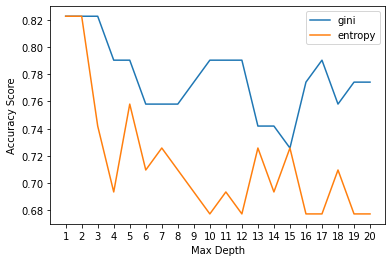

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depth = []
acc_gini = []
acc_entropy = []

for i in range(1,21):
  dtree = DecisionTreeClassifier(criterion = "gini", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_gini.append(accuracy_score(Y_test,pred))

  dtree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
  dtree.fit(X_train,Y_train)
  pred = dtree.predict(X_test)
  acc_entropy.append(accuracy_score(Y_test,pred))

  max_depth.append(i)

df = pd.DataFrame({"acc_gini" : pd.Series(acc_gini),
                   "acc_entropy" : pd.Series(acc_entropy), 
                   "max_depth" : pd.Series(max_depth)})

plt.plot("max_depth", "acc_gini", data = df, label = "gini")
plt.plot("max_depth", "acc_entropy", data = df, label = "entropy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.xticks([j for j in range(1,21)])
plt.legend()
plt.show()

In [277]:
DT_model51 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [278]:
DT_model52 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [279]:
DT_model53 = DecisionTreeClassifier(criterion = "gini", max_depth = 3)

In [280]:
#Training sub51 on the model
DT_model51.fit(X_sub51,Y_sub51)

#Training sub52 on the model
DT_model52.fit(X_sub52,Y_sub52)

#Training sub53 on the model
DT_model53.fit(X_sub53,Y_sub53)

DecisionTreeClassifier(max_depth=3)

In [ ]:
#predict sub51 the results
y_dt51 = DT_model51.predict_proba(X_valid_f)

#predict sub52 the results
y_dt52 = DT_model52.predict_proba(X_valid_f)

#predict sub53 the results
y_dt53 = DT_model53.predict_proba(X_valid_f)

In [ ]:
#Finalization
DT_data = {"probs_mean_sub51": y_dt51.mean(axis = 0) , 
      "probs_mean_sub52": y_dt52.mean(axis = 0),
      "probs_mean_sub53": y_dt53.mean(axis = 0)}

DT5 = pd.DataFrame(DT_data, index = ["class0", "class1", "class2", "class3"])
DT5

,probs_mean_sub51,probs_mean_sub52,probs_mean_sub53
class0,0.379793,0.379182,0.376273
class1,0.183001,0.188673,0.166879
class2,0.207844,0.216855,0.226800
class3,0.229362,0.215290,0.230048


In [281]:
#predict sub11 the results
yr_dt51 = DT_model51.predict(X_valid_f)

#predict sub12 the results
yr_dt52 = DT_model52.predict(X_valid_f)

#predict sub13 the results
yr_dt53 = DT_model53.predict(X_valid_f)

In [306]:
#Accuracy Score
acc_score51 = accuracy_score(y_valid_f,yr_dt51)
acc_score52 = accuracy_score(y_valid_f,yr_dt52)
acc_score53 = accuracy_score(y_valid_f,yr_dt53)

#Precicion Score (Sensitivity)
pr_score51 = precision_score(y_valid_f,yr_dt51, average = "macro")
pr_score52 = precision_score(y_valid_f,yr_dt52, average = "macro")
pr_score53 = precision_score(y_valid_f,yr_dt53, average = "macro")

#Recall Score (Speceficity)
re_score51 = recall_score(y_valid_f,yr_dt51, average = "macro")
re_score52 = recall_score(y_valid_f,yr_dt52, average = "macro")
re_score53 = recall_score(y_valid_f,yr_dt53, average = "macro")

#F1-Score
f1_score51 = recall_score(y_valid_f,yr_dt51, average = "macro")
f1_score52 = recall_score(y_valid_f,yr_dt52, average = "macro")
f1_score53 = recall_score(y_valid_f,yr_dt53, average = "macro")


#Finalization
DT_data5 = {"acc_score": [acc_score51,acc_score52,acc_score53] , 
      "pr_score": [pr_score51,pr_score52,pr_score53],
      "recall_score": [re_score51,re_score52,re_score53],
      "f1-Score" : [f1_score51,f1_score52,f1_score53]}

DT5 = pd.DataFrame(DT_data5, index = ["subset51", "subset52", "subset53"])
DT5

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall

,acc_score,pr_score,recall_score,f1-Score
subset51,0.429577,0.291882,0.206614,0.206614
subset52,0.366197,0.282143,0.193165,0.193165
subset53,0.461268,0.305173,0.210805,0.210805


# **Finalization**

For Probabilities

In [ ]:
result_df = pd.concat([RF1,RF2,RF3,RF4,RF5,LR1,LR2,LR3,LR4,LR5,DT1,DT2,DT3,DT4,DT5], axis = 1)
result_df

,probs_mean_sub11,probs_mean_sub12,probs_mean_sub13,probs_mean_sub21,probs_mean_sub22,probs_mean_sub23,probs_mean_sub31,probs_mean_sub32,probs_mean_sub33,probs_mean_sub41,...,probs_mean_sub23,probs_mean_sub31,probs_mean_sub32,probs_mean_sub33,probs_mean_sub41,probs_mean_sub42,probs_mean_sub43,probs_mean_sub51,probs_mean_sub52,probs_mean_sub53
class0,0.326678,0.341011,0.330806,0.322384,0.309454,0.327052,0.323979,0.306604,0.334126,0.338051,...,0.376235,0.279800,0.303710,0.328527,0.365054,0.370386,0.293026,0.379793,0.379182,0.376273
class1,0.216691,0.210198,0.214570,0.223031,0.218718,0.217909,0.222819,0.241595,0.218380,0.207431,...,0.173776,0.210648,0.225023,0.191143,0.179603,0.175117,0.168284,0.183001,0.188673,0.166879
class2,0.222724,0.213321,0.214181,0.220084,0.227085,0.223398,0.219298,0.220224,0.223317,0.221129,...,0.240065,0.288346,0.238205,0.259161,0.219186,0.233424,0.315012,0.207844,0.216855,0.226800
class3,0.233907,0.235471,0.240442,0.234501,0.244742,0.231641,0.233905,0.231577,0.224177,0.233389,...,0.209924,0.221206,0.233063,0.221169,0.236157,0.221073,0.223677,0.229362,0.215290,0.230048


In [ ]:
final_results = pd.DataFrame(result_df.mean(axis = 1), columns = ["Probabilities"])
final_results

,Probabilities
class0,0.318426
class1,0.210480
class2,0.233322
class3,0.237771


For Real Values

In [313]:
final_results_real = pd.concat([RF1,RF2,RF3,RF4,RF5,
                                LR1,LR2,LR3,LR4,LR5,
                                DT1,DT2,DT3,DT4,DT5], axis = 0)
final_results_real

,acc_score,pr_score,recall_score,f1-score,f1-Score
subset11,0.552817,0.308012,0.232485,0.232485,NaN
subset12,0.556338,0.295708,0.228445,0.228445,NaN
subset13,0.559859,0.300813,0.229474,0.229474,NaN
subset21,0.580986,0.312951,0.245784,0.245784,NaN
subset22,0.549296,0.293973,0.226388,0.226388,NaN
subset23,0.475352,0.283644,0.209851,0.209851,NaN
subset31,0.531690,0.298116,0.221244,0.221244,NaN
subset32,0.492958,0.292697,0.214995,0.214995,NaN
subset33,0.563380,0.301413,0.230503,0.230503,NaN
subset41,0.496479,0.294444,0.205887,0.205887,NaN


In [316]:
final_results_real.iloc[:,3].mean()

0.22172015088305358

In [288]:
means_final_results_real = pd.DataFrame(final_results_real.mean(axis = 0), columns = ["mean_of_result"])
means_final_results_real

,mean_of_result
acc_score,0.487402
pr_score,0.296757
recall_score,0.218122


# *Histogram of Train, Test, and Validation*

In [ ]:
##count 0 value

#For Validation
label_0_v = eval_df[eval_df["Label"] == 0].shape
print(label_0_v[0])
#For Test
label_0_tt = test_df[test_df["Label"] == 0].shape
print(label_0_tt[0])
#For Train
label_0_tn = train_df[train_df["Label"] == 0].shape
print(label_0_tn[0])

print("\n")

##count 1 value

#For Validation
label_1_v = eval_df[eval_df["Label"] == 1].shape
print(label_1_v[0])
#For Test
label_1_tt = test_df[test_df["Label"] == 1].shape
print(label_1_tt[0])
#For Train
label_1_tn = train_df[train_df["Label"] == 1].shape
print(label_1_tn[0])

131
157
608


114
149
616


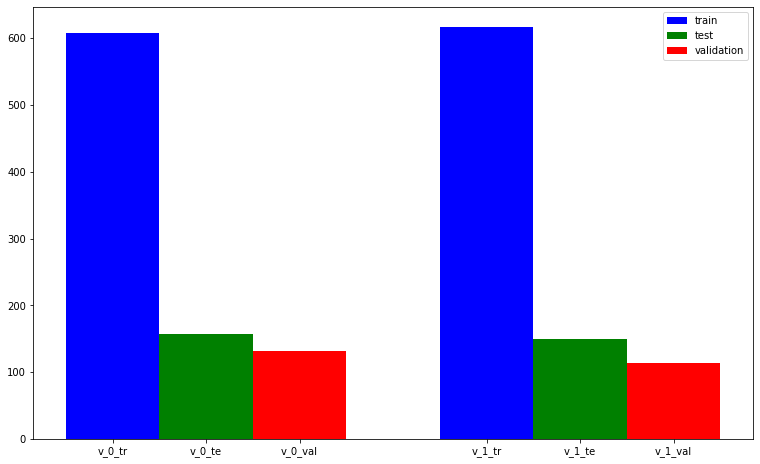

In [ ]:
data = [[608, 616],
[157,149],
[131,114]]
X = np.arange(2)
fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(X, data[0], color = 'b', width = 0.25, label = "train")
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25, label = "test")
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25, label = "validation")

plt.xticks([0,0.25,0.5,1,1.25,1.5],["v_0_tr", "v_0_te", "v_0_val", "v_1_tr", "v_1_te", "v_1_val"])
plt.legend()
plt.show()

# **Data Set: COVIDSQUARED_DiagnosticData**

## **Main**

In [ ]:
data = pd.read_csv("COVIDSQUARED_DiagnosticData.csv")

In [ ]:
data_vivo = data[data["End Point"] == "vivo"]
data_morto = data[data["End Point"] == "morto"]

In [ ]:
data_morto1 = data_morto.sort_values("Giorni FU", ascending = True).reset_index().drop("index", axis = 1)

In [ ]:
data_morto_0_170 = data_morto1.iloc[0:171,:].replace({"End Point" : "morto"}, "morto1")
data_morto_171_249 = data_morto1.iloc[171:250,:].replace({"End Point" : "morto"}, "morto2")
data_morto_250_314 = data_morto1.iloc[250:315,:].replace({"End Point" : "morto"}, "morto3")

data_morto2 = pd.concat([data_morto_0_170, data_morto_171_249, data_morto_250_314], axis = 0)

In [ ]:
data1 = pd.concat([data_vivo, data_morto2], axis = 0).reset_index().drop("index", axis = 1)

In [ ]:
data_main = data1_[data1_["Record_Name"] <= 1118]

In [ ]:
data_main

,Record_Name,TWaveAsymm,AvgTWavePower,Vindex,Sex,Age,PP_1.0_Values,PP_1.0_Samples_1,PP_2.0_Values,PR_1.0_Values,...,QRS_Pseudo_Vector_5/8_Spatial_Velocity,QRS_Pseudo_Vector_6/8_Spatial_Velocity,QRS_Pseudo_Vector_7/8_Spatial_Velocity,QRS_Pseudo_Vector_Maximum_Amplitude,LVH_Score,LV_Strain,QT_Dispersion,QT_Corrected,P_Terminal,Label
0,2.0,-18.756256,0.053923,52.791134,1.0,64.0,778.0,194.0,822.0,134.0,...,179.0,59.0,16.0,2039.0,248.0,0.0,60.0,411.0,2992.0,0.0
1,3.0,-23.200995,0.047182,18.527581,1.0,54.0,770.0,163.0,788.0,160.0,...,37.0,54.0,21.0,1017.0,0.0,0.0,40.0,411.0,3200.0,0.0
2,4.0,-27.740684,0.281762,24.966689,1.0,62.0,742.0,277.0,638.0,94.0,...,65.0,97.0,65.0,1386.0,0.0,0.0,18.0,408.0,1428.0,0.0
3,5.0,-19.785063,0.023113,26.480089,0.0,56.0,568.0,265.0,560.0,162.0,...,18.0,44.0,27.0,886.0,200.0,0.0,60.0,388.0,0.0,0.0
4,6.0,-27.125650,0.129315,76.392076,0.0,72.0,1040.0,179.0,986.0,132.0,...,95.0,43.0,53.0,2443.0,284.8,0.0,46.0,454.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1114.0,-28.151170,0.203832,18.929508,1.0,73.0,976.0,222.0,1010.0,172.0,...,45.0,16.0,10.0,696.0,57.0,0.0,46.0,404.0,5616.0,0.0
996,1115.0,-27.024761,0.017324,24.540700,0.0,84.0,714.0,447.0,792.0,134.0,...,54.0,25.0,15.0,816.0,0.0,0.0,72.0,442.0,2800.0,1.0
997,1116.0,-27.941616,0.039733,25.799912,0.0,27.0,566.0,327.0,572.0,184.0,...,160.0,81.0,16.0,1509.0,56.0,0.0,40.0,428.0,0.0,0.0
998,1117.0,-27.183155,0.040171,31.097336,0.0,27.0,586.0,295.0,614.0,188.0,...,139.0,98.0,17.0,1525.0,106.0,0.0,42.0,423.0,0.0,0.0


In [ ]:
records = []
for i in data_main["Record_Name"].astype(int):
  records.append(i)

In [ ]:
data_vm = data.iloc[records, :].drop(219, axis = 0)
data_vm

,Original File,Mapped File,Date of recording,Year DoR,Month DoR,Day DoR,DoR,New PAT ID per ECG,PAT ID per ECG,PAT NAME,...,PAT DOB,Year,Month,Day,PAT ID univoco per Pz,First name,Family name,End Point,Date o FU,Giorni FU
2,100503690_20201017153723.FDA.xml,FILE.000252.FDA.xml,2.020100e+13,2020,10,17,17/10/20,SBJ_000000141,100503690,NaN,...,NaN,NaN,NaN,NaN,583,NaN,NaN,vivo,11/2/2021,381
3,100501575_20200914140908.FDA.xml,FILE.000229.FDA.xml,2.020090e+13,2020,9,14,14/09/20,SBJ_000000123,100501575,NaN,...,NaN,NaN,NaN,NaN,18,NaN,NaN,vivo,11/2/2021,414
4,100501575_20200916104006.FDA.xml,FILE.000230.FDA.xml,2.020090e+13,2020,9,16,16/09/20,SBJ_000000123,100501575,NaN,...,NaN,NaN,NaN,NaN,18,NaN,NaN,vivo,11/2/2021,412
5,100501575_20200912110712.FDA.xml,FILE.000228.FDA.xml,2.020090e+13,2020,9,12,12/9/2020,SBJ_000000123,100501575,NaN,...,NaN,NaN,NaN,NaN,18,NaN,NaN,vivo,11/2/2021,416
6,100501575_20200911111524.FDA.xml,FILE.000227.FDA.xml,2.020090e+13,2020,9,11,11/9/2020,SBJ_000000123,100501575,NaN,...,NaN,NaN,NaN,NaN,18,NaN,NaN,vivo,11/2/2021,417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,1468653_20200710122843.FDA.xml,FILE.000906.FDA.xml,2.020070e+13,2020,7,10,10/7/2020,SBJ_000000517,1468653,NaN,...,NaN,NaN,NaN,NaN,311,NaN,NaN,vivo,11/2/2021,480
1115,1468653_20200720165909.FDA.xml,FILE.000908.FDA.xml,2.020070e+13,2020,7,20,20/07/20,SBJ_000000517,1468653,NaN,...,NaN,NaN,NaN,NaN,311,NaN,NaN,vivo,11/2/2021,470
1116,1468653_20200908122020.FDA.xml,FILE.000910.FDA.xml,2.020090e+13,2020,9,8,8/9/2020,SBJ_000000517,1468653,NaN,...,NaN,NaN,NaN,NaN,311,NaN,NaN,vivo,11/2/2021,420
1117,100069383_20200611145333.FDA.xml,FILE.000012.FDA.xml,2.020060e+13,2020,6,11,11/6/2020,SBJ_000000011,100069383,NaN,...,NaN,NaN,NaN,NaN,89,NaN,NaN,vivo,11/2/2021,509


In [ ]:
data_vm1 = data_vm.iloc[:,[-3,-1]]
data_vm1

,End Point,Giorni FU
2,vivo,381
3,vivo,414
4,vivo,412
5,vivo,416
6,vivo,417
...,...,...
1114,vivo,480
1115,vivo,470
1116,vivo,420
1117,vivo,509


In [ ]:
data_vm2 = data_vm1[data_vm1["End Point"] == "morto"]
data_vm3 = data_vm2.sort_values("Giorni FU", ascending = True)

In [ ]:
data_vm3["morto_record"] = [j for j in range(1,277)]
data_vm4 = data_vm3.drop("End Point", axis = 1)

In [ ]:
data_vm4

,Giorni FU,morto_record
1108,0,1
871,0,2
143,0,3
868,0,4
654,0,5
...,...,...
54,371,272
161,378,273
159,384,274
160,384,275


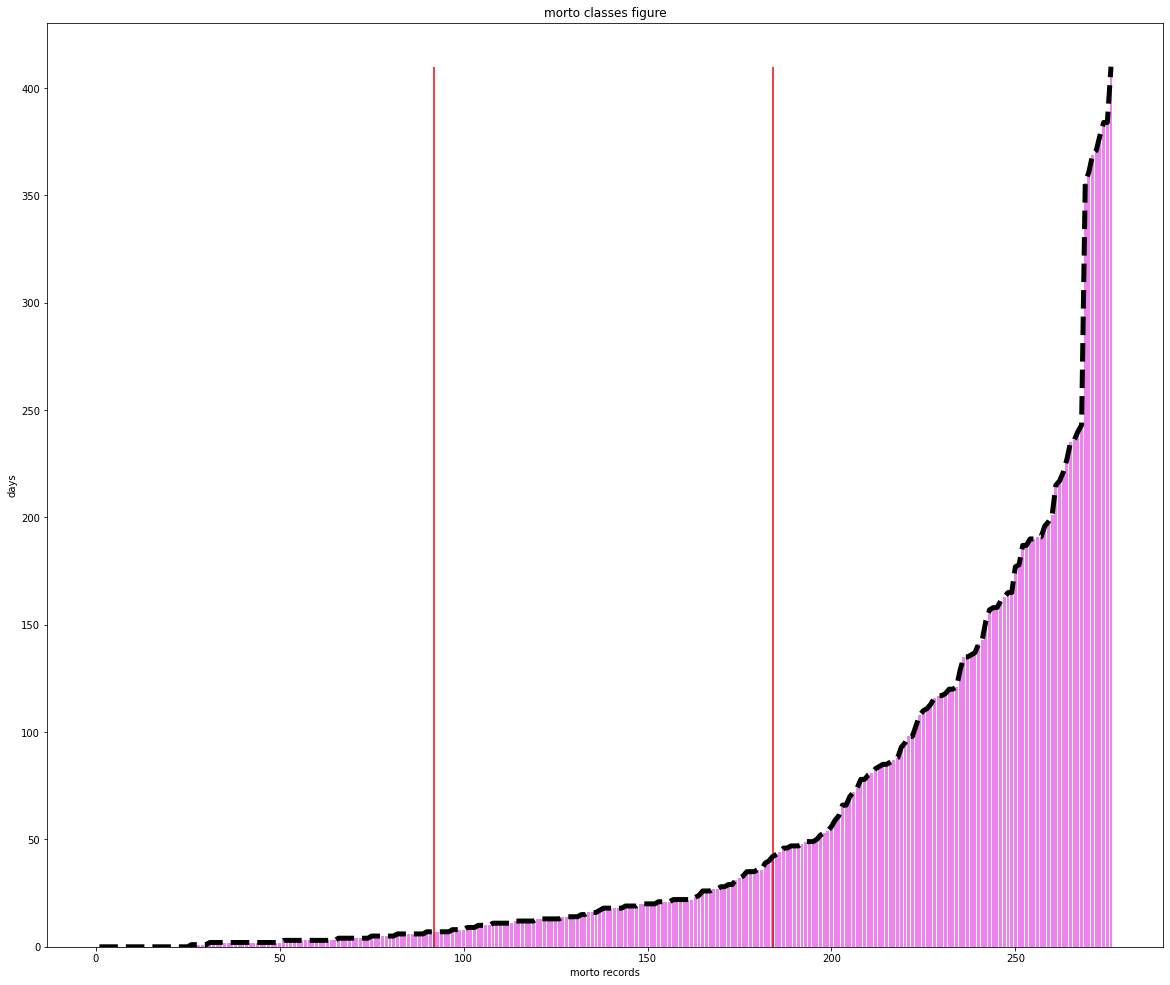

In [ ]:
fig = plt.figure(figsize =(20, 17))
plt.bar(data_vm4.iloc[:,1], data_vm4.iloc[:,0], color = "violet")
plt.vlines(92, 0, 410, color='red')
plt.vlines(184, 0, 410, color='red')
plt.plot("morto_record", "Giorni FU", 'g--', data = data_vm4, color = "black", linewidth = 5)
plt.title("morto classes figure")
plt.xlabel("morto records")
plt.ylabel("days")
plt.yticks([j for j in range(0,411,50)])
plt.show()

In [ ]:
data_vivo = data_vm[data_vm["End Point"] == "vivo"]
data_morto = data_vm[data_vm["End Point"] == "morto"]

In [ ]:
data_morto1 = data_morto.sort_values("Giorni FU", ascending = True)

In [ ]:
data_morto_0_92 = data_morto1.iloc[0:92,:].replace({"End Point" : "morto"}, "morto1")
data_morto_92_184 = data_morto1.iloc[92:184,:].replace({"End Point" : "morto"}, "morto2")
data_morto_184_276 = data_morto1.iloc[184:277,:].replace({"End Point" : "morto"}, "morto3")

data_morto2 = pd.concat([data_morto_0_92, data_morto_92_184, data_morto_184_277], axis = 0)

In [ ]:
data_vm6 = pd.concat([data_vivo, data_morto2], axis = 0)

In [ ]:
record = list(data_vm6[data_vm6["End Point"] != "vivo"].index)

In [ ]:
main_record = []
for j in data_main["Record_Name"].astype(int):
  if j not in record:
    continue
  main_record.append(j)

In [ ]:
data_main["Record_Name"].astype(int)

0         2
1         3
2         4
3         5
4         6
       ... 
995    1114
996    1115
997    1116
998    1117
999    1118
Name: Record_Name, Length: 1000, dtype: int64

In [ ]:
data_main

,Record_Name,TWaveAsymm,AvgTWavePower,Vindex,Sex,Age,PP_1.0_Values,PP_1.0_Samples_1,PP_2.0_Values,PR_1.0_Values,...,QRS_Pseudo_Vector_5/8_Spatial_Velocity,QRS_Pseudo_Vector_6/8_Spatial_Velocity,QRS_Pseudo_Vector_7/8_Spatial_Velocity,QRS_Pseudo_Vector_Maximum_Amplitude,LVH_Score,LV_Strain,QT_Dispersion,QT_Corrected,P_Terminal,Label
0,2.0,-18.756256,0.053923,52.791134,1.0,64.0,778.0,194.0,822.0,134.0,...,179.0,59.0,16.0,2039.0,248.0,0.0,60.0,411.0,2992.0,0.0
1,3.0,-23.200995,0.047182,18.527581,1.0,54.0,770.0,163.0,788.0,160.0,...,37.0,54.0,21.0,1017.0,0.0,0.0,40.0,411.0,3200.0,0.0
2,4.0,-27.740684,0.281762,24.966689,1.0,62.0,742.0,277.0,638.0,94.0,...,65.0,97.0,65.0,1386.0,0.0,0.0,18.0,408.0,1428.0,0.0
3,5.0,-19.785063,0.023113,26.480089,0.0,56.0,568.0,265.0,560.0,162.0,...,18.0,44.0,27.0,886.0,200.0,0.0,60.0,388.0,0.0,0.0
4,6.0,-27.125650,0.129315,76.392076,0.0,72.0,1040.0,179.0,986.0,132.0,...,95.0,43.0,53.0,2443.0,284.8,0.0,46.0,454.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1114.0,-28.151170,0.203832,18.929508,1.0,73.0,976.0,222.0,1010.0,172.0,...,45.0,16.0,10.0,696.0,57.0,0.0,46.0,404.0,5616.0,0.0
996,1115.0,-27.024761,0.017324,24.540700,0.0,84.0,714.0,447.0,792.0,134.0,...,54.0,25.0,15.0,816.0,0.0,0.0,72.0,442.0,2800.0,1.0
997,1116.0,-27.941616,0.039733,25.799912,0.0,27.0,566.0,327.0,572.0,184.0,...,160.0,81.0,16.0,1509.0,56.0,0.0,40.0,428.0,0.0,0.0
998,1117.0,-27.183155,0.040171,31.097336,0.0,27.0,586.0,295.0,614.0,188.0,...,139.0,98.0,17.0,1525.0,106.0,0.0,42.0,423.0,0.0,0.0
